# Eurovision Turing Data Story

> Exploring (non-musical) factors contributing to Eurovision votes in the past 25 years.

- toc: false
- categories: [data wrangling, data visualisation, bayesian modeling, random forest, eurovision]
- author(s): Ed Chapman, Katriona Goldmann, Radka Jersakova, David Llewellyn-Jones, Joe Palmer, Camila Rangel Smith, Martin Stoffel, Jonathan Yong
- image: TODO

**Authors**
 - Ed Chapman
 - Katriona Goldmann
 - Radka Jersakova
 - David Llewellyn-Jones
 - Joe Palmer
 - Camila Rangel Smith
 - Martin Stoffel
 - Jonathan Yong
 
 **Reviewers:**
- Reviewer 1
- Reviewer 2

# Introduction

The Eurovision Song Contest, or *Eurovision* for short, is an annual competition featuring (mostly) European countries. It is in fact the longest running international televised music competition, having started in 1951 as what was then seen as a technical experiment in transnational live broadcasting. The competition has continued every year since &mdash; except in 2020 when it was cancelled, [much to Iceland's chagrin](https://youtu.be/1HU7ocv3S2o), due to the pandemic &mdash; and has grown in terms of number of countries participating, musical variety, visual flair and (some might say) fantastical preposterousness.

Despite the name, the Eurovision Song Content is neither about Europe, nor Singing. According to the Eurovision website, the European Broadcasting Union which runs the contest is made up of "56 countries and an additional 31 Associates in Asia, Africa, Australasia and the Americas". The contest itself is billed as a *songwriting* competition.

There are [strict requirements](https://eurovision.tv/about/rules) that songs and performers must comply with. Songs must be original; under three minutes long; sung live without lip syncing and with no live plugging instruments.

Typically the winning country is expected to host the technically challenging and costly event the following year (a 'prize' that [allegedly led to](https://www.irelandbeforeyoudie.com/why-ireland-stopped-winning-eurovision/) Ireland entering sub-par acts for at least a decade in a deliberate attempt to avoid winning). As many readers will no-doubt be aware, in 2022 the competition was won by Kalush Orchestra from Ukraine, with their song [Stefania](https://youtu.be/F1fl60ypdLs). This would ordinarily mean the 2023 event would have been held in Ukraine, however this was deemed unsafe in light of the Russian invasion. The UK (the 2022 runners-up) therefore stepped in, meaning that in 2023 the contest was held in Liverpool, 9–13 May.

The seventy-year history of the event means there is now a large body of data about it to work with, as well as a large number of great songs to listen to. As you work through this Turing Data Story, we strongly recommend you listen to some of the great Eurovision masterpieces as your backing track, from the likes of [Celine Dion](https://youtu.be/w6b7BHGkKQA), [Bucks Fizz](https://youtu.be/h4-lKMGII_k), [Lordi](https://youtu.be/gAh9NRGNhUU), [Loreen](https://youtu.be/Pfo-8z86x80) and of course [Abba](https://youtu.be/Vp1_OKawHYw).

<center>
    <img alt="meme comparing what I think I look like discussing eurovision: two men casually talking to sofa; to what I actually look like: Charlie Kelly looking wild-eyed in front of a peg board full of conspiracy connections" src="https://i.imgur.com/WVNzMI7.jpeg" />
</center>

In the current format, participating countries first take part in a semifinal; the top 10 from each semifinal qualify for the finals.
The host country, as well as the "Big Five" (France, Germany, Italy, Spain, and the UK, which make greater financial contributions), directly qualify for the finals.

We have pooled data from a number of different sources with the aim of understanding trends in the contest voting patterns. We have also tried to make the data as accessible as possible. The curated data frame is available in the `data/df_main.csv` file, and the code to create this dataset is in `data.ipynb`.

We used this dataset to predict the winners of the [2023 event in Liverpool](https://eurovision.tv/event/liverpool-2023). Now that the event has taken place we've left this analysis as-is, so that you can compare our predictions with the actual results. But we've also now been able to add some post-match analysis to reflect on how our models did so that we can be even more accurate next year.

In this notebook we'll go into some detail about all of our data collection, analysis and results. If you're here for instant gratification and just want to know how we did, check out our summary on the [Turing Institute Blog](https://www.turing.ac.uk/blog/can-data-science-help-us-predict-winner-eurovision-2023). But if you want to know all the gory data-sciency details, then read on!

## Setup

We begin by importing packages and setting up any configuration needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import seaborn as sns
from IPython.display import clear_output

sns.set_theme(style="whitegrid")

# Data

In order to explore the characteristics of Eurovision, with the aim of making predictions for the 2023 event, we first need to collect historical data about contests prior to 2023. We will obviously need to know what scores were assigned to which acts in previous years, but we also want to explore other factors that might potentially affect the success or otherwise of the performances.

It has long [been claimed](https://www.datalytyx.com/eurovision-song-contest-regression-analysis-highlights-the-voting-patterns/) that there is a [measurable bias](https://www.tandfonline.com/doi/full/10.1080/02664763.2014.909792) in relation to which countries vote for which other countries at Eurovision. We should therefore gather data that exhibits these biases. We also consider other factors that may affect voting patterns, such as the gender of the performer or language of the song.

The Eurovision Song Contest has undergone several changes to its voting system since it began in 1956. These changes were made to increase transparency and reduce the impact of regional bloc voting, while still allowing for a fair and entertaining competition.

In the early years, the winning country was selected by a jury of experts from each participating country. In 1975, a new system was introduced that combined jury voting with telephone voting by viewers at home. Over time, the weight of the jury and viewer votes has shifted, with viewer votes becoming more influential. In 2016, the voting system was revised again, with separate scores given for jury and viewer votes, and a new system for calculating the final scores. 

In order to model uniform voting scores over time, we limited our analysis to contests from 1998 onwards, where the jury and televoting scores are equally weighted.

In the following sections we'll describe our data-wrangling efforts in some depth. If you're more interested in the analysis, then you can safely skip forwards to the [Covariate visualisation section](#Covariate-visualisation) without losing the narrative.

## Voting Scores

Our voting data was pulled from the following sources: 

- From the [Eurovision Song Contest Scores Kaggle dataset](https://www.kaggle.com/datasets/datagraver/eurovision-song-contest-scores-19752019), for the years 1998–2019. 
- The 2020 contest was cancelled due to Covid. 
- The [2021](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2021#Final_2) and [2022](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2022#Final_2) contest scores were scraped from Wikipedia.

The jury votes have in the past been replaced with a substitute aggregate due to potential bias or 'irregularities'. In this case, new jury scores were calculated ["based on the results of other countries with similar voting records"](https://eurovision.tv/mediacentre/release/ebu-statement-voting-during-2022-shows). However, this is not very transparent and [not captured by our models](https://eurovisionworld.com/esc/here-is-the-proof-of-the-eurovision-voting-scandal-six-juries-cheated-and-voted-for-each-other).

Unlike in earlier years, since 2016 the jury and televoting scores have been reported separately. Simply summing these would lead to scores that are unusually large compared to previous years. In order to bring this in line, both votes were summed and rescaled by mapping the highest result to 12 points, second-highest to 10 points, and so on.

For the data collection process the code is hidden for brevity, but available by opening out the sections in case you still want to view it.

To begin we load in the Kaggle data which we host ourself to avoid having to negotiate with Kaggle's authentication wall.

In [2]:
#| code-fold: true
## Read in data from the Kaggle dataset
votes_1975_2019 = pd.read_excel('data/eurovision_song_contest_1975_2019.xlsx', engine='openpyxl')
print('Number of entries: {}'.format(len(votes_1975_2019)))
votes_1975_2019.head()

Number of entries: 49832


Year (semi-) final Edition Jury or Televoting From country To country  \
0  1975             f   1975f                  J      Belgium    Belgium   
1  1975             f   1975f                  J      Belgium    Finland   
2  1975             f   1975f                  J      Belgium     France   
3  1975             f   1975f                  J      Belgium    Germany   
4  1975             f   1975f                  J      Belgium    Ireland   

   Points       Duplicate  
0             0         x  
1             0       NaN  
2             2       NaN  
3             0       NaN  
4            12       NaN

The dataset requires some cleaning up before we can properly make use of it. Some of this is due to errors that have crept into the dataset such as incorrect spellings of country names, some is due to geopolitical changes during the period we're considering (we have mapped all entries by the entity 'Serbia & Montenegro' to Yugoslavia), and some is needed to get the dataset structured appropriately for our analysis.

In [3]:
#| code-fold: true
# Clean up the column names
votes_1975_2019.columns = [c.strip().lower().replace(' ', '_') for c in votes_1975_2019.columns.values.tolist()]

# Select only finals votes, and only 1998 onwards (inclusive)
votes_1998_2019 = votes_1975_2019[(votes_1975_2019['(semi-)_final'] == 'f') & (votes_1975_2019['year'] >= 1998)]

# Drop unnecessary columns
votes_1998_2019 = votes_1998_2019[["year", "from_country", "to_country", "points", "jury_or_televoting"]]

# Clean up country names
def standardise_country(c):
    replacements = [('-', ' '), ('&', 'and'), ('Netherands', 'Netherlands'),
                    # FYR Macedonia was formally renamed as North Macedonia in 2019
                    ('F.Y.R. Macedonia', 'North Macedonia'), 
                    ('Russia', 'Russian Federation'), 
                    ('The Netherlands', 'Netherlands'), 
                    ('Czech Republic', 'Czechia'),
                    # Yugoslavia dissolved in 2002; most of it became 'Serbia and Montenegro', until 2006, when Serbia and Montenegro split ways.
                    ('Serbia and Montenegro', 'yugoslavia'),
                    ('moldova', 'moldova, republic of')]
    for r in replacements:
        c = c.replace(r[0], r[1])
    return c.lower()

votes_1998_2019[['from_country', 'to_country']] = votes_1998_2019[['from_country', 'to_country']].map(standardise_country)

# Drop columns which correspond to the same vote (there are two Belarus -> Russia in 2019, for example)
votes_1998_2019 = votes_1998_2019.drop_duplicates(subset=['year', 'from_country', 'to_country', 'jury_or_televoting'])

# Drop Lithuania in 2003 (they didn't participate - we don't know why it's still in the dataset)
votes_1998_2019 = votes_1998_2019[~((votes_1998_2019['to_country'] == 'lithuania') & (votes_1998_2019['year'] == 2003))]

# Drop "votes" from one country to itself
votes_1998_2019 = votes_1998_2019[votes_1998_2019['from_country'] != votes_1998_2019['to_country']]

votes_1998_2019.sample(n=10)

year from_country              to_country  points jury_or_televoting
30378  2013      albania                   malta       0                  J
35874  2016       israel              azerbaijan       0                  J
12943  2002        spain                  israel       0                  J
30508  2013      belgium                   malta       0                  J
48084  2019      belarus               australia       2                  T
35346  2016    australia                 georgia       0                  J
49772  2019     portugal                 albania       0                  J
13235  2003      germany  bosnia and herzegovina       0                  J
32216  2014      estonia                  norway       3                  J
26674  2011      austria  bosnia and herzegovina      12                  J

The Kaggle dataset runs up to 2019, but we need data for 2021 and 2022 as well (recall that there was no contest in 2020). We collect these data from the tables in the Wikipedia pages for the [2021](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2021#Final_2) and [2022](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2022#Final_2) contests respectively.

The process of downloading and cleaning up this data is rather long winded, so we're going to skip past that here and instead refer to the separate [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb) that we've put together for the inquisitve.

So we'll short-circuit this by grabbing the output from the data collection notebook. Or, in the immortal words of the Blue Peter team, here's one I made earlier:

In [4]:
#| code-fold: true
votes = pd.read_csv('data/votes.csv')
votes.head()

year from_country       to_country  points from_code2 from_code3 to_code2  \
0  1998      belgium          croatia       5         BE        BEL       HR   
1  1998      belgium           cyprus       2         BE        BEL       CY   
2  1998      belgium          estonia       0         BE        BEL       EE   
3  1998      belgium  north macedonia       0         BE        BEL       MK   
4  1998      belgium          finland       0         BE        BEL       FI   

  to_code3  total_points  rank  
0      HRV           131   5.0  
1      CYP            37  11.0  
2      EST            36  12.0  
3      MKD            16  19.0  
4      FIN            22  15.0

## Performance language

The next step is to collect together the languages used in the songs. We're particularly interested in whether the song is sung in the language of the performing country or some other language. Anecdotally there has been a tendency for songs to be sung in English if not a country's native language, and so we also keep track of whether a song includes English lyrics as well.

When collecting the data, we have to bear in mind that songs are often sung in *more than one* language. The fields we've chosen to populate are therefore:
 - *whether the song contains English lyrics*,
 - *whether it contains non-English lyrics*,
 - *whether it contains the performing country's official language*,
 - *whether it contains the voting country's official language*, and
 - *whether it contains multiple languages*.

We retreived information about the language of each performance from a dataset [available from Kaggle](https://www.kaggle.com/datasets/minitree/eurovision-song-lyrics?select=eurovision-lyrics-2022.json). This provides us with half of our needs; the other half relates to which languages are the official languages of each country. For the latter we scrape the list of official languages available [on Wikipedia](https://en.wikipedia.org/wiki/List_of_official_languages_by_country_and_territory).

Again, the data needed considerable cleaning and structuring to suit our needs. We'll skip the code for doing this for brevity and refer the interested reader to our data collection notebook.

In [5]:
#| code-fold: true
df_VL = pd.read_csv('data/language.csv')
df_VL.head()

year from_country       to_country  points from_code2 from_code3 to_code2  \
0  1998      belgium          croatia       5         BE        BEL       HR   
1  1998      belgium           cyprus       2         BE        BEL       CY   
2  1998      belgium          estonia       0         BE        BEL       EE   
3  1998      belgium  north macedonia       0         BE        BEL       MK   
4  1998      belgium          finland       0         BE        BEL       FI   

  to_code3  total_points  rank  ...  Year Country_code2_y Country_code3  \
0      HRV           131   5.0  ...  1998              HR           HRV   
1      CYP            37  11.0  ...  1998              CY           CYP   
2      EST            36  12.0  ...  1998              EE           EST   
3      MKD            16  19.0  ...  1998              MK           MKD   
4      FIN            22  15.0  ...  1998              FI           FIN   

  Contains_English Contains_NonEnglish   Official_languages  \
0            False                True             croatian   
1            False                True        greek turkish   
2            False                True        võro estonian   
3            False                True  macedonian albanian   
4            False                True      finnish swedish   

  Contains_Multiple_Languages Number_of_Languages  Contains_Own_Language  \
0                       False                   1                   True   
1                       False                   1                   True   
2                       False                   1                   True   
3                       False                   1                   True   
4                       False                   1                   True   

   Contains_Voting_Language  
0                     False  
1                     False  
2                     False  
3                     False  
4                     False  

[5 rows x 25 columns]

## Performer gender

To establish the gender of the various performers we capture the *'gender'* property available from [Wikidata](https://www.wikidata.org/wiki/Wikidata:List_of_properties), using code that's based on Sam Van Stroud's [wikipeople script](https://github.com/samvanstroud/wikipeople/blob/master/wikipeople/wikipeople.py).

Rather than referring directly to our [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb) we've kept the code here, since it demonstrates some nice techniques. You'll still need to unfold the cells to view the details.

Establishing gender isn't straightforward in all cases. For example, many Eurovision entries are group performances. For these we detect the *'instance of'* Wikidata property, checking whether it's equal to one of *group*, *duo*, *trio*, *music*, *band* or *ensemble*. There are also non-binary performers to consider.

Searching Wikidata with a name often generates multiple hits, so we try to restrict our search to performers tagged as being musicians and tagged as having performed at Eurovision. Even with this restriction we don't always get a unique hit, or any hit at all. Some artists simply don't exist in the database, or are missing these tags. Out of the total 600 performers we are left having to manually assign genders to 55 of them.

In [6]:
#| code-fold: true
import aiohttp
import asyncio

async def get_property(session, concept_id, property_id):
    """Async reimplementation of wikipeople.get_property
    https://github.com/samvanstroud/wikipeople/blob/master/wikipeople/wikipeople.py

    session is an aiohttp ClientSession instance.
    concept_id refers to a person or a group, and can be obtained using the get_concept_id function.
    property_id refers to a certain property of the given entity referred to by the concept_id.

    Returns None if any of this can't be found for whatever reason.

    e.g. "Q219655" is the concept_id for Carey Mulligan; "P21" is the property_id for gender.
    So we have that get_property(session, "Q219655", "P21") -> "female".
    """
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbgetclaims",
        "entity": concept_id,
        "property": property_id,
        "language": "en",
        "format": "json",
    }
    async with session.get(url, params=params) as resp:
        try:
            res = await resp.json()
        except Exception as e:
            print(resp)
            raise e

    if property_id not in res["claims"]:
        return None
    # This gives yet another 'id', and we then need to perform yet another HTTP
    # request to find the actual *label* that this corresponds to.
    else:
        id = None
        for prop in res["claims"][property_id]:
            try:
                id = prop["mainsnak"]["datavalue"]["value"]["id"]
            except:
                continue

        if id is None:
            return None
        else:
            new_params = {
                "action": "wbgetentities",
                "ids": id,
                "languages": "en",
                "format": "json",
                "props": "labels",
            }
            async with session.get(url, params=new_params) as resp:
                try:
                    res = await resp.json()
                except Exception as e:
                    print(resp)
                    raise e
            try:
                return res["entities"][id]["labels"]["en"]["value"]
            except:
                return None


async def get_concept_id(session, page_name):
    """
    Get the concept_id corresponding to a particular Wikipedia page. For some odd reason, some Wikipedia
    pages don't have concept IDs. In such a case, we return None.

    e.g. get_concept_id(session, "Carey Mulligan") -> "Q219655"
    """
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "search": page_name,
        "language": "en",
        "format": "json",
    }
    music_markers = [
        "singer",
        "artist",
        "musician",
        "music",
        "band",
        "group",
        "duo",
        "ensemble",
    ]

    async with session.get(url, params=params) as resp:
        # Titles of WP pages that match the search query.
        json = await resp.json()

    result = json["search"]

    if len(result) == 0:
        # Couldn't find a concept id for the person/group
        return None

    # By default, choose the first result from the list
    target = 0
    # But check the other results to see if any of them are musicians (as
    # indicated by the markers) and Eurovision contestants
    for i, res in enumerate(result):
        if "description" in res["display"]:
            description = res["display"]["description"]["value"]
            if any(markers in description for markers in music_markers):
                concept_id = res["id"]
                contestant_in = await get_property(session, concept_id, "P1344")
                if contestant_in is not None and "Eurovision" in contestant_in:
                    target = i
    # Return the concept ID of the result found
    return result[target]["id"]


async def lookup_gender(session, page_name):
    """Find gender of a performing act, using the name associated with their
    Wikipedia page. Returns None if could not be found.
    """
    concept_id = await get_concept_id(session, page_name)
    if concept_id is None:
        return None

    gender = await get_property(session, concept_id, "P21")
    instance = await get_property(session, concept_id, "P31")
    if gender is None and instance is None:
        return None
    elif gender is None and instance is not None:
        group_checks = ["group", "duo", "trio", "music", "band", "ensemble"]
        if any(x in instance for x in group_checks):
            return "group"
    else:
        return gender


async def get_pages(session, name):
    """Obtain a list of Wikipedia pages obtained by searching for a name."""
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "opensearch",
        "namespace": "0",
        "search": name,
        "limit": "10000",
        "format": "json",
    }
    async with session.get(url, params=params) as resp:
        # Titles of WP pages that match the search query.
        json = await resp.json()
    return json[1]


async def get_artist_gender(session, name):
    gender = None
    # Get the WP page for this person/group
    pages = await get_pages(session, name)
    # If there's one, try to get their gender from the first page
    if len(pages) > 0:
        gender = await lookup_gender(session, pages[0])
    # Finally we use some heuristics to cover some edge cases
    if gender is None:
        if "&" in name or "feat." in name:
            return "group"

    return gender

The next bit of code pulls the list of artists from the data we already collected above. We use an async function to make multiple HTTP requests simultaneously and greatly decrease the overall time needed to work through the list.

Having extracted as much as possible from Wikidata the code then performs the manual fixes to complete the missing entries, and to ensure transgender entries are regarded as simply *male* or *female* as appropriate. Finally the results are merged in with our existing data.

In [7]:
#| code-fold: true
all_performers = df_VL['Artist'].unique().tolist()
n_performers = len(all_performers)
MAX_CONCURRENT = 40   # To stop Wikipedia from complaining about 'too many requests'
USER_AGENT = 'Eurovision study @ The Alan Turing Institute mailto:jyong@turing.ac.uk'

async def get_all_genders():
    genders = []
    print(f'Fetching genders of {n_performers} performers, in batches of {MAX_CONCURRENT}. Hold tight...')
    async with aiohttp.ClientSession(headers={'User-Agent': USER_AGENT}) as session:
        start = 0
        end = MAX_CONCURRENT
        while start < n_performers:
            print(f'Getting genders for performers #{start + 1} to #{end}... ', end='')
            batch_tasks = asyncio.gather(*[get_artist_gender(session, p) for p in all_performers[start:end]])
            batch_genders = await batch_tasks
            print(f'Got {len(batch_genders)} results, {len([g for g in batch_genders if g is None])} of which were None.')
            genders = genders + batch_genders
            start = end
            end = min(end + MAX_CONCURRENT, n_performers)
            await asyncio.sleep(1.5)   # Put a pause between batches to avoid being timed out

    assert len(genders) == n_performers  # Check for off-by-one errors
    print('Finished downloading gender data.')
    clear_output(wait=True)
    return dict(zip(all_performers, genders))

gender_dict = await get_all_genders()

# Manually assign missing entries (the Nones).
male = ['Michael Hajiyanni', 'Charlie', 'Tüzmen', 'Mietek Szcześniak', 'Olexandr', 'Max', 'Brinck',
        'Sakis Rouvas (2)', 'Gianluca', 'Frans', 'Chingiz', 'Mahmood', 'Serhat (2)', 'Miki', 'Stefan']
female = ['Gunvor', 'Selma', 'Charlotte Nilsson (Perrelli)', 'Karolina', 'Laura', 'Rosa', 'Lou', 'Nicola',
        'Karmen', 'Sanda', 'Ortal', 'Gracia', 'Chiara (2)', 'Hanna', 'Chiara (3)', 'Elena', 'Lena (2)',
        'Birgit', 'Samra', 'ZAA Sanja Vučić', 'Anja', 'Alma', 'Netta', 'Michela', 'Efendi', 'Victoria',
        'Destiny', 'Amanda Georgiadi Tenfjord', 'MARO']
group = ['Eden', 'Voice', 'Taxi', 'One', 'Prime Minister', 'Fame', 'Regina (band)', 'ESDM',
        'Tolmachevy Sisters', 'Minus One', 'AWS']
for p in male:
    gender_dict[p] = "male"
for p in female:
    gender_dict[p] = "female"
for p in group:
    gender_dict[p] = "group"

# Wikipedia needs to learn that 'trans woman' is 'female'.
for k, v in gender_dict.items():
    if v == 'trans woman':
        gender_dict[k] = 'female'

# Add gender to the dataframe.
df_VLG = df_VL.copy()
df_VLG['gender'] = df_VLG['Artist'].map(gender_dict)
df_VLG.head()

We need to fetch the genders of 600 performers, in batches of 40. Hold tight...
Getting genders for performers #1 to #40... Got 40 results, 6 of which were None.
Getting genders for performers #41 to #80... Got 40 results, 3 of which were None.
Getting genders for performers #81 to #120... Got 40 results, 6 of which were None.
Getting genders for performers #121 to #160... Got 40 results, 7 of which were None.
Getting genders for performers #161 to #200... Got 40 results, 3 of which were None.
Getting genders for performers #201 to #240... Got 40 results, 2 of which were None.
Getting genders for performers #241 to #280... Got 40 results, 4 of which were None.
Getting genders for performers #281 to #320... Got 40 results, 2 of which were None.
Getting genders for performers #321 to #360... Got 40 results, 1 of which were None.
Getting genders for performers #361 to #400... Got 40 results, 3 of which were None.
Getting genders for performers #401 to #440... Got 40 results, 0 of which we

year from_country       to_country  points from_code2 from_code3 to_code2  \
0  1998      belgium          croatia       5         BE        BEL       HR   
1  1998      belgium           cyprus       2         BE        BEL       CY   
2  1998      belgium          estonia       0         BE        BEL       EE   
3  1998      belgium  north macedonia       0         BE        BEL       MK   
4  1998      belgium          finland       0         BE        BEL       FI   

  to_code3  total_points  rank  ... Country_code2_y Country_code3  \
0      HRV           131   5.0  ...              HR           HRV   
1      CYP            37  11.0  ...              CY           CYP   
2      EST            36  12.0  ...              EE           EST   
3      MKD            16  19.0  ...              MK           MKD   
4      FIN            22  15.0  ...              FI           FIN   

  Contains_English Contains_NonEnglish   Official_languages  \
0            False                True             croatian   
1            False                True        greek turkish   
2            False                True        võro estonian   
3            False                True  macedonian albanian   
4            False                True      finnish swedish   

   Contains_Multiple_Languages Number_of_Languages Contains_Own_Language  \
0                        False                   1                  True   
1                        False                   1                  True   
2                        False                   1                  True   
3                        False                   1                  True   
4                        False                   1                  True   

   Contains_Voting_Language  gender  
0                     False  female  
1                     False    male  
2                     False    male  
3                     False    male  
4                     False   group  

[5 rows x 26 columns]

## Migration data

Migration data were gathered to report on the estimated migration betweeen each voting–performing country pair that have previously competed. 

Data were collected from two sources. First we took migration data from [Our World in Data](https://ourworldindata.org/migration) under the 'Explore data on where people migrate from and to' section. The underlying data originate from the UN. The data show the total number of immigrants in each country split by country of origin in the years 1990–2020, recorded at intervals of every 5 years.

We clean up the data so that the country names match those we're already using and filter on countries that participate in Eurovision.

In [8]:
#| code-fold: true
migration = (pd.read_csv('data/migration-flows.csv')
    .pipe(pd.melt, id_vars=['Country', 'Year'], var_name='Migration', value_name='Count')  # to long format
    .loc[lambda x: x['Migration'].str.contains('Emigrants')]                               # filter for emigrant rows
    .pipe(lambda x: x.rename(columns = {col: col.lower() for col in x.columns}))           # lowercase column names                                                         
    .assign(migration = lambda x: x.migration.str.replace('Emigrants from ', ''))          # filter for emigrant rows                          
    .rename(columns={'migration': 'emigrated_from', 'country': 'emigrated_to'})            # boil down to country name
    .query('count >= 0')                                                                   # negative counts are just total emigrants from country
    .pipe(lambda x: x.assign(count = x['count'].astype(int)))                              # convert count to int     
)

# Clean up country names
for ft in ['from', 'to']:
    migration[f'emigrated_{ft}'] = migration[f'emigrated_{ft}'].str.lower()
    migration.loc[migration[f'emigrated_{ft}'] == 'moldova', f'emigrated_{ft}'] = 'moldova, republic of'
    migration.loc[migration[f'emigrated_{ft}'] == 'russia', f'emigrated_{ft}'] = 'russian federation'

# Remove non-Eurovision countries
ev_countries = set(df_VLG['from_country']).union(set(df_VLG['to_country']))
migration = migration[(migration['emigrated_to'].isin(ev_countries)) & (migration['emigrated_from'].isin(ev_countries))]

# Add in country codes
def get_country_codes(name):
    return df_VLG[df_VLG['from_country'] == name].iloc[0][['from_code2', 'from_code3']]

for ft in ['from', 'to']:
    migration[f'emigrated_{ft}_code2'], migration[f'emigrated_{ft}_code3'] = zip(*migration[f'emigrated_{ft}'].map(get_country_codes))

We note that we're able to get data for all of the countries except Yugoslavia which is missing from the dataset.

In [9]:
#| code-fold: true
migration_countries = set(migration['emigrated_to']).union(set(migration['emigrated_from']))
print('Eurovision countries without data: {}'.format(''.join(ev_countries - migration_countries)))  # No data for Yugoslavia.

Eurovision countries without data: yugoslavia


In order to provide a fairer comparison we convert absolute migration numbers into proportions of the population size of each country. For this we also need country population data, which we collected from the [World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL?end=2021&start=2021&view=map).

In [10]:
#| code-fold: true
pop_size = (pd.read_csv('data/pop_sizes.csv')
           .iloc[:, 3:]
           .rename(columns=lambda x: x.lower().replace(' ', '_'))
           .pipe(pd.melt, id_vars=['country_code'], var_name='year', value_name='population')
           .assign(year=lambda x: x['year'].apply(lambda y: y.split('_')[0]))
           .assign(year=lambda x: x['year'].astype(int))
           .rename(columns={'country_code': 'code3'})
           .dropna()
           .assign(population=lambda x: pd.to_numeric(x['population'], errors='coerce'))
)

migration_and_pop = (migration.merge(pop_size, left_on=['year', 'emigrated_to_code3'], right_on=['year', 'code3'], how='left')
                    .rename(columns={'population': 'population_to'})
                    .assign(prop_emigrants=lambda x: x['count'] / x['population_to'])
                    )

The UN migration data are recorded in five year intervals, so for each year of Eurovision data we assign the most recent recording. In essence, we end up repeating each row of the migration data five times, once for each of the following four years.

In [11]:
#| code-fold: true
migration_and_pop['migration_pop_year'] = migration_and_pop['year']

total_migration_and_pop = migration_and_pop.copy()
for i in range(1, 5):
    next_migration_and_pop = migration_and_pop.copy()
    next_migration_and_pop['year'] = next_migration_and_pop['year'] + i
    total_migration_and_pop = pd.concat([total_migration_and_pop, next_migration_and_pop], ignore_index=True)

total_migration_and_pop = total_migration_and_pop.sort_values(by=["emigrated_from", "emigrated_to", "year"])
total_migration_and_pop = total_migration_and_pop[['emigrated_from_code2', 'emigrated_to_code2', 'year', 'count', 'population_to', 'prop_emigrants', 'migration_pop_year']]

# Output a sample of the data including only some of the more relevant columns
total_migration_and_pop[['emigrated_to_code2', 'emigrated_from_code2', 'year', 'population_to', 'prop_emigrants']].sample(5)

emigrated_to_code2 emigrated_from_code2  year  population_to  \
16761                 IE                   GE  2006      4159914.0   
57832                 RO                   NO  2019     19815616.0   
26570                 PT                   BE  2017     10358076.0   
24198                 IE                   UA  2021      4985382.0   
46133                 BY                   RO  2008      9663915.0   

       prop_emigrants  
16761        0.000072  
57832        0.000013  
26570        0.000330  
24198        0.001049  
46133        0.000002

Finally we integrate this with our existing dataset. We'll skip this step for brevity and pull the data in direction from the [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb). The result is our original dataframe with additional columns with migration and population data. Note the caveat that we're not working with perfect data here: we don't have data for Yugoslavia, and our data are repeated for the unrecorded years between the five year intervals.

In [12]:
#| code-fold: true
df_VLGM = pd.read_csv('data/migration.csv')

## Competition winners

Traditionally, the winner of each Eurovision contest becomes the host country for the following year's contest, which is considered to be an expensive operation. This has led to a recurring argument that many countries do not want to win, and therefore put in less effort. At the same time, it has previously been proposed that the number of years since a country's last win influences how likely they are to do well due to how competitive their performance is.

In order to investigate this, we calculated how long each performing country had gone without a win in Eurovision. To achieve this, the previous contest winners were gathered from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Eurovision_Song_Contest_winners) and integrated into our existing dataset. We'll skip this step for brevity and pull the data in from the [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb).

In [13]:
#| code-fold: true
df_VLGMC = pd.read_csv('data/comps_without_win.csv')

# Output a sample of the data for 2022, including only some of the more relevant columns
df_VLGMC[df_VLGMC['year'] == 2022][['to_country', 'comps_without_win']].sample(5)

to_country  comps_without_win
20405  switzerland                 32
20395    lithuania                 65
20700      ukraine                  4
20978       france                 43
20342       france                 43

## Shared border

It's been suggested that neighbouring countries may be *more* &mdash; or contrariwise *less* &mdash; likely to vote for one another than countries further away. Is this really the case, and if so, which is it? Or is it just a case of commentator cynicism and *post-hoc* rationalisation?

We decided to find out by adding shared borders between countries into our model. We collected these country border data from [GeoDataSource](https://github.com/geodatasource/country-borders/). This only includes land borders, so sea borders are not considered.  For the detailed process of cleaning up and merging the data into our dataset, see the [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb).

In [14]:
#| code-fold: true
# This represents our final dataset for the historical data
df = df_VLGMCB = pd.read_csv('data/df_main.csv')

# Output a sample of the data including only some of the more relevant columns
df_VLGMCB[['from_country', 'to_country', 'has_border']].sample(5)

from_country to_country  has_border
19527                cyprus    belgium       False
11907              slovenia    denmark       False
12674                latvia    hungary       False
15774  moldova, republic of     cyprus       False
10868              slovenia    ukraine       False

In [15]:
#| code-fold: true
print('Years covered: {} to {}'.format(df['year'].min(), df['year'].max()))

Years covered: 1998 to 2022


## 2023 performers

Existing data sources have provided data covering all previous years up to 2022. As we noted above, we restrict our data to 1998 onwards so that we can focus on years in which both public and jury voting was used.

Our model will make predictions based on the parameters we've provided &mdash; things like the country a performer is from, their gender and the language of the song &mdash; which means that in order to make predictions for 2023, we'll need to know the same characteristics for the 2023 entries. Our model can then use these characteristics in combination with the historical data, to predict the ranking, or scores, of the performances for 2023.

The final step in the collection of our data is therefore to find information about the upcoming performances in 2023. These data were gathered from [Wikipedia](https://en.wikipedia.org/wiki/Eurovision_Song_Contest_2023). Some of the parameters for which we weren't able to obtain more recent data &mdash; such as migration numbers &mdash; we repeat the entries from previous years.

The code for pulling these data together repeats many of the steps we described earlier for the historical data, and so we won't go through the details again here. You can see the full process in the [data collection notebook](https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/story_notebook/eurovision/notebooks/data.ipynb). As usual we will pull in the results as they were output from that notebook and just review a sample.

This gives us all of the data we need. In the next section we'll examine these data and find out what they tell us about Eurovision entries and voting patterns.

In [16]:
#| code-fold: true
future = pd.read_csv('data/df_2023.csv')

# Output a sample of the data including only some of the more relevant columns
future[['to_country', 'gender', 'Contains_English', 'Contains_NonEnglish', 'comps_without_win']].sample(5)

to_country  gender  Contains_English  Contains_NonEnglish  \
1109     poland  female              True                False   
260     ireland   group              True                False   
899     estonia  female              True                False   
9        norway  female              True                False   
64        malta   group              True                False   

      comps_without_win  
1109                 66  
260                  26  
899                  20  
9                    12  
64                   66

# Exploratory Visualisations

Before we start modelling, we explore patterns in the data through summary statistics and visualisations. The aim here is to gain an intuition about trends, relationships between variables, potential quirks and outliers and voting patterns between countries.

## Best performing countries

Let's first have a look at the winners in each year from 1998 to 2022:

In [17]:
winners = (df.loc[df['rank'] == 1, ['to_country', 'total_points', 'rank', 'to_code2', 'year']]
             .drop_duplicates()
             )
winners

to_country  total_points  rank to_code2  year
10                 israel           172   1.0       IL  1998
618                sweden           163   1.0       SE  1999
1109              denmark           195   1.0       DK  2000
1660              estonia           198   1.0       EE  2001
2176               latvia           176   1.0       LV  2002
2737               turkey           167   1.0       TR  2003
3362              ukraine           280   1.0       UA  2004
4188               greece           230   1.0       GR  2005
5098              finland           292   1.0       FI  2006
5998               serbia           268   1.0       RS  2007
6982   russian federation           272   1.0       RU  2008
8030               norway           387   1.0       NO  2009
9049              germany           246   1.0       DE  2010
9991           azerbaijan           221   1.0       AZ  2011
11061              sweden           372   1.0       SE  2012
12110             denmark           281   1.0       DK  2013
13095             austria           290   1.0       AT  2014
14054              sweden           365   1.0       SE  2015
15107             ukraine           308   1.0       UA  2016
16169            portugal           421   1.0       PT  2017
17227              israel           309   1.0       IL  2018
18321         netherlands           299   1.0       NL  2019
19357               italy           302   1.0       IT  2021
20358             ukraine           379   1.0       UA  2022

Winning Eurovision is hard! Only four countries have managed to win more than once since 1998, and only Ukraine 🇺🇦 and Sweden 🇸🇪  won three times.

In [18]:
multiple_winners = winners['to_country'].value_counts().loc[lambda x: x > 1]
multiple_winners

ukraine    3
sweden     3
israel     2
denmark    2
Name: to_country, dtype: int64

Winning is one thing, but which countries perform best _on average_? To make this statistic a bit more robust, we only look at countries that have made the finals at least five times within the timeframe we're considering (see the `count` variable).
Over this period, Italy 🇮🇹 has the highest average score, closely followed by Bulgaria 🇧🇬.

In [19]:
highest_scorers = (df.loc[:, ['to_country', 'to_code2', 'total_points', 'year']]
                   .drop_duplicates()
                   .groupby('to_country')['total_points']
                   .agg(['count', 'mean'])
                   .query('count >= 5')
                   .round({'mean': 2})
                   .sort_values(by='mean', ascending=False)
                   .head()
                   )
highest_scorers

count    mean
to_country                       
italy                  11  170.55
bulgaria                5  166.40
ukraine                17  156.65
russian federation     19  153.47
sweden                 23  142.04

While summary statistics like the average can be informative, it would be really interesting to see how well a country is doing over the years in a bit more detail.
Are the top performing countries always much better than average, or do a few great perfomances lift up the average scores of these countries?

To visualise this for different countries, we create a function to plot the scores of a country over time and mark specific years where the country either didn't perform in the final at all or where it has actually won the competition.

In [20]:
#| code-fold: true
my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: y / 26

def plot_country_history(country, ax, df_plot):
    df_country_entries = (df_plot
                          .loc[df_plot['to_country'] == country]
                          .sort_values('year', ascending=False)
                          )
    country_name = df_country_entries['to_country'].iloc[0].title()

    # Add in NaN entries for years where the country did not perform in the finals
    present_years = df_country_entries['year'].unique()
    absent_years = list(set(range(1998, 2023)) - set(present_years))
    df_absent_entries = pd.DataFrame(dict(year=absent_years, total_points=np.nan,
                        rank= np.nan, to_country=country))
    df_country_entries = pd.concat([df_country_entries, df_absent_entries], ignore_index=True)

    # Plot data
    ax.bar(df_country_entries['year'], df_country_entries['total_points'],
            color=my_cmap(rescale(df_country_entries['rank'])))

    # Annotate absent entries, with a special marker for 2020 (cancelled)
    for year in absent_years:
        marker = "_" if year == 2020 else "x"
        ax.scatter(x=year, y=0.03, s=25, color='grey', marker=marker, transform=ax.get_xaxis_transform())

    # Annotate winning entries
    winning_entries = df_country_entries.loc[df_country_entries['rank'] == 1, ['year', 'total_points']].drop_duplicates()
    if winning_entries.shape[0] > 0:
        ax.scatter(x=winning_entries['year'], y=winning_entries['total_points'], s=50, color='gold', marker="*", edgecolor='black', zorder=5)

    ax.set_xlim(1997, 2023)
    ax.set_title(country_name)

Before looking at the top performers, let's first have a look at the United Kingdom 🇬🇧. Every couple of years, the UK has a good year with a top-ten position, but hasn't come first since 1997 with [Katrina and the Waves](https://www.youtube.com/watch?v=azw4Kh8Rqpw) (not in our dataset). 2022 was the most successful year since then, with Sam Ryder becoming second with the song [Space Man](https://www.youtube.com/watch?v=RZ0hqX_92zI).

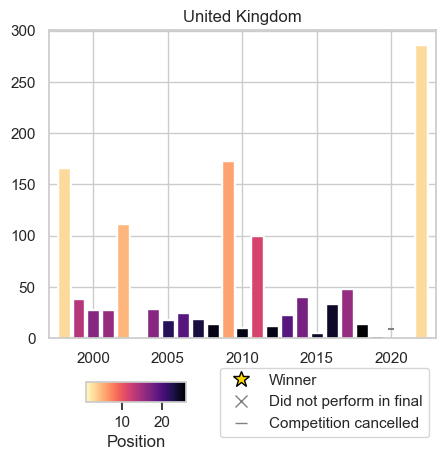

In [21]:
#| code-fold: true
fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True, sharex=True, squeeze=True)

plot_country_history('united kingdom', ax, df)

legend_elements = [Line2D([0], [0], marker='*', color='white', label='Winner',
                          markerfacecolor='gold', markersize=12, markeredgecolor='black'),                          
                  Line2D([0], [0], marker='x', color='white', label='Did not perform in final',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey'), 
                  Line2D([0], [0], marker='_', color='white', label='Competition cancelled',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey')]
fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.9, -0.05))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.2, -0.05, 0.2, 0.05]) # x y deltax deltay

fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', 
             cax = cbaxes)

plt.show()

Compared to the UK, how do the _most successful_ countries perform over the years? We'll have a look at the top four countries, for both the total and the average scores.

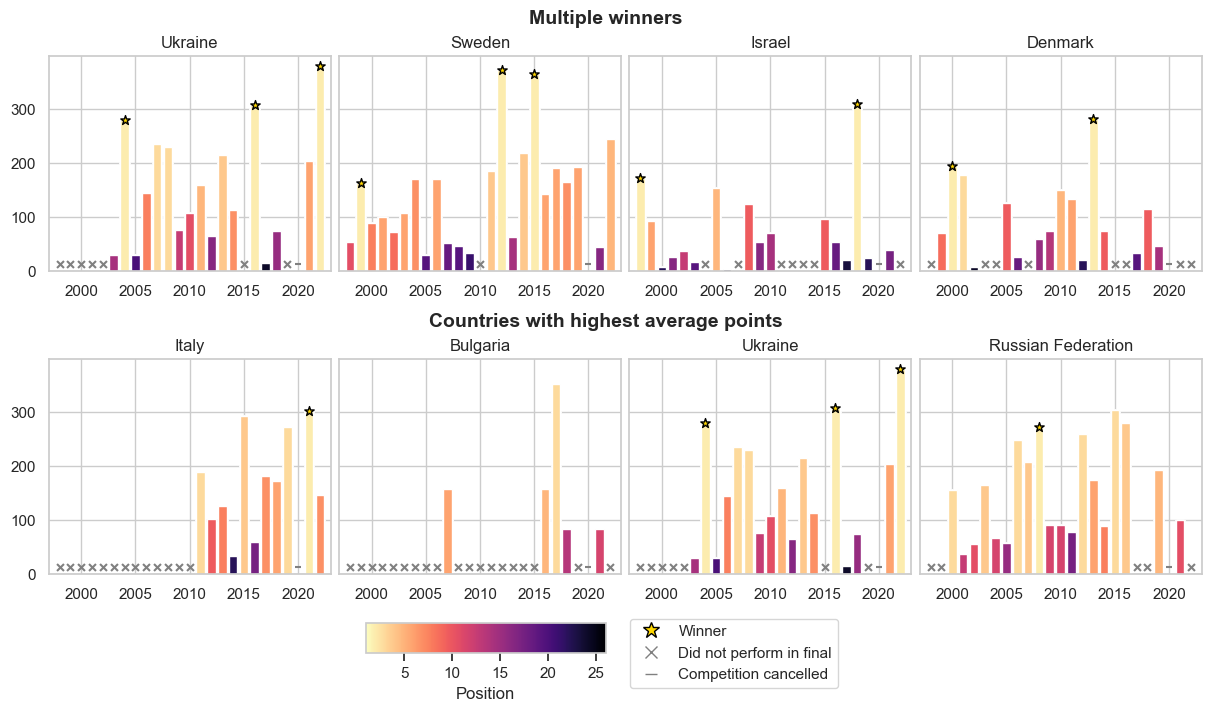

In [22]:
#| code-fold: true
fig = plt.figure(layout='constrained', figsize=(12, 6))
subfigs = fig.subfigures(2, 1, wspace=0.1)

for subfig, country_group, title in zip(subfigs,
                                        [multiple_winners, highest_scorers],
                                        ['Multiple winners', 'Countries with highest average points']
                                        ):
    axs = subfig.subplots(1, 4, sharey=True, sharex=True, squeeze=True)
    subfig.suptitle(title, fontsize=14, fontweight='bold')
    for i, country in enumerate(country_group.index[:4]): 
        plot_country_history(country, axs[i], df)

# Add in colorbar and legend
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.3, -0.08, 0.2, 0.05]) # x y deltax deltay
fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', cax=cbaxes)
fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.7, -0.08))

plt.show()

There's a clear difference to the picture of the UK here.
Ukraine 🇺🇦 and Sweden 🇸🇪 have not only won three times each, but have also placed within the top ten many times over the years (indicated by the lighter bars).
Some countries haven't participated very often, but have done really well the few times they did, such as Bulgaria 🇧🇬.
This is reflected in their second-place ranking in the table of average scores.

## Voting patterns between country pairs

There is a lot more to explore in the Eurovision data.
Countries are performing but are also voting for each other.
Do countries mainly vote for the actual performance or are the some general biases between countries?
To dig deeper into this, we'll explore voting patterns between country pairs.

We start by calculating the score each country has given to each other country, averaged over all years.

In [23]:
df_voting = (df.loc[:, ['from_country', 'points', 'to_country', 'year']]
               .assign(average_vote=lambda x: x.groupby(['to_country', 'from_country'])['points'].transform('mean'))
               .drop_duplicates(subset=['from_country', 'to_country'])
               .loc[:, ['from_country', 'to_country', 'average_vote']]
               .pivot(index='from_country', columns='to_country', values='average_vote')
               )
df_voting.head()

to_country     albania   armenia  australia   austria  azerbaijan   belarus  \
from_country                                                                  
albania            NaN  0.909091   2.500000  0.714286    2.307692  0.333333   
andorra       0.000000  0.000000        NaN  0.000000    3.500000  0.000000   
armenia       0.000000       NaN   0.666667  1.500000    0.090909  3.833333   
australia     0.000000  0.000000        NaN  0.250000    0.000000  0.000000   
austria       3.142857  2.714286   4.000000       NaN    2.000000  0.600000   

to_country     belgium  bosnia and herzegovina  bulgaria   croatia  ...  \
from_country                                                        ...   
albania       0.250000                5.333333      5.40  1.142857  ...   
andorra       1.000000                0.000000      0.00  0.000000  ...   
armenia       1.333333                1.000000      3.00  0.400000  ...   
australia     4.800000                     NaN      4.25  0.000000  ...   
austria       1.727273                8.750000      4.20  5.000000  ...   

to_country      serbia  slovakia  slovenia      spain    sweden  switzerland  \
from_country                                                                   
albania       1.363636       NaN  0.000000   3.388889  2.705882     3.142857   
andorra       0.000000       NaN  0.000000  10.000000  2.833333     0.500000   
armenia       1.555556       NaN  0.000000   1.571429  3.230769     2.600000   
australia     2.166667       NaN  0.000000   2.428571  6.571429     4.333333   
austria       6.111111       NaN  0.666667   0.333333  4.055556     3.875000   

to_country    turkey   ukraine  united kingdom  yugoslavia  
from_country                                                
albania        8.875  1.937500        1.888889         6.5  
andorra        0.500  5.500000        1.000000         1.0  
armenia        0.800  6.000000        0.642857         NaN  
australia        NaN  5.400000        3.000000         NaN  
austria        5.625  2.538462        1.333333        12.0  

[5 rows x 47 columns]

We can plot a *heatmap* to illustrate this data.
In this color scheme we have chosen, darker squares indicate a *larger* average vote given by one country to another.

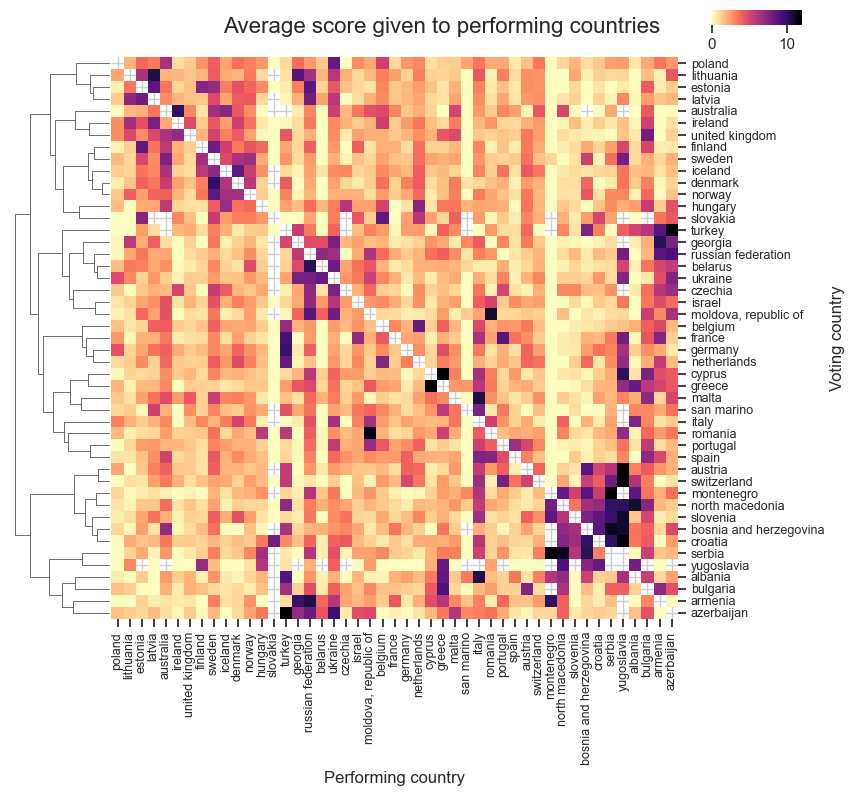

In [24]:
#| code-fold: true
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

def plot_voting_heatmap(df_heatmap, cmap, suptitle, center=None):
    # Reindex rows to be in the same order as columns
    df_heatmap = df_heatmap.reindex(df_heatmap.columns)

    row_dism = 1 - df_heatmap.T.corr()
    row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')
    plot = sns.clustermap(df_heatmap, row_linkage=row_linkage, col_linkage=row_linkage, 
                          figsize=(9, 8),
                          mask=df_heatmap.isnull(), 
                          dendrogram_ratio=[0.15, 0.01],
                          cbar_pos=(0.8, 1.01, 0.1, 0.019),
                          cbar_kws={'orientation': 'horizontal'},
                          cmap=cmap, 
                          xticklabels=1,
                          yticklabels=1,
                          **{'center': center} if center is not None else {})
    plot.ax_col_dendrogram.set_visible(False) 

    plot.fig.suptitle(suptitle, fontsize=16, y=1.02)
    plot.ax_heatmap.set_xlabel('Performing country')
    plot.ax_heatmap.set_ylabel('Voting country')
    plot.ax_heatmap.tick_params(axis='both', which='major', labelsize=9)
    plot.ax_heatmap.xaxis.tick_bottom()   # otherwise x-axis ticks disappear, see: mwaskom/seaborn#2305
    return plot

plot_voting_heatmap(df_voting, cmap='magma_r', suptitle='Average score given to performing countries')
plt.show()

In this plot, countries are grouped using hierarchical clustering, ordering countries with similar voting patterns together. 

From here, we can see a few patterns emerging.
Some countries tend to vote higher for each other, forming darker squares in the heatmap.
One such square in the bottom right is around Slovenia 🇸🇮, Bosnia and Herzegovina 🇧🇦, Croatia 🇭🇷, and Serbia 🇷🇸, which all give each other relatively high votes on average.

However, the *votes* alone don't say that much.
As we've already seen, some countries simply tend to perform well at Eurovision; this would naturally make their average received scores larger!
To extract this factor from the analysis, so that we can look into potential country-pair voting biases, we therefore look for *deviations* from a country's average performance score.
Essentially, we are asking whether a certain country gives higher or lower votes to another country, compared to all other countries.

We start by calculating the voting deviations from the mean each country receives. 

In [25]:
df_voting_deviation = (df.loc[:, ['from_country', 'points', 'to_country', 'year']]
                          # This is the average vote from one country to another, the same as above.
                         .assign(average_vote=lambda x: x.groupby(['to_country', 'from_country'])['points'].transform('mean'))
                          # This is the average vote received by one country from all others.
                         .assign(average_votes_all=lambda x: x.groupby(['to_country'])['points'].transform('mean'))
                          # Calculate the deviation from the mean.
                         .assign(vote_deviation=lambda x: x['average_vote'] - x['average_votes_all'])
                          # We drop any voter-performer pairs for which there are fewer than three votes, as this is likely
                          # not representative of the country's true voting pattern.
                         .assign(count=lambda x: x.groupby(['from_country', 'to_country'])['vote_deviation'].transform('count'))
                         .query('count >= 3')
                         .drop_duplicates(subset=['from_country', 'to_country'])
                         .loc[:, ['from_country', 'to_country', 'vote_deviation']]
                         .pivot(index='from_country', columns='to_country', values='vote_deviation')
                         )
df_voting_deviation.head()

to_country     albania   armenia  australia   austria  azerbaijan   belarus  \
from_country                                                                  
albania            NaN -1.716775  -0.929752 -1.768099   -0.630292 -0.970085   
andorra      -1.738579 -2.625866        NaN       NaN         NaN       NaN   
armenia      -1.738579       NaN  -2.763085 -0.982385   -2.847075  2.529915   
australia    -1.738579 -2.625866        NaN -2.232385   -2.937984       NaN   
austria       1.404278  0.088420   0.570248       NaN   -0.937984 -0.703419   

to_country     belgium  bosnia and herzegovina  bulgaria   croatia  ...  \
from_country                                                        ...   
albania      -2.430751                2.812081  1.301478 -0.907867  ...   
andorra            NaN               -2.521253       NaN -2.050725  ...   
armenia      -1.347418               -1.521253 -1.098522 -1.650725  ...   
australia     2.119249                     NaN  0.151478       NaN  ...   
austria      -0.953478                6.228747  0.101478  2.949275  ...   

to_country    russian federation  san marino    serbia  slovenia     spain  \
from_country                                                                 
albania                -1.621569    2.719298 -1.439975 -1.269663  1.957285   
andorra                -1.954902         NaN       NaN       NaN  8.568396   
armenia                 6.166310         NaN -1.248056 -1.269663  0.139825   
australia              -1.288235         NaN -0.636945 -1.269663  0.996968   
austria                -1.645378   -0.614035  3.307499 -0.602996 -1.098270   

to_country      sweden  switzerland    turkey   ukraine  united kingdom  
from_country                                                             
albania      -1.327451     0.975210  5.600664 -2.128149        0.447851  
andorra      -1.200000          NaN -2.774336  1.434351       -0.441038  
armenia      -0.802564     0.432353 -2.474336  1.934351       -0.798181  
australia     2.538095     2.165686       NaN  1.334351        1.558962  
austria       0.022222     1.707353  2.350664 -1.527187       -0.107704  

[5 rows x 44 columns]

We can now plot the same heatmap, but with the deviations instead of the actual votes.

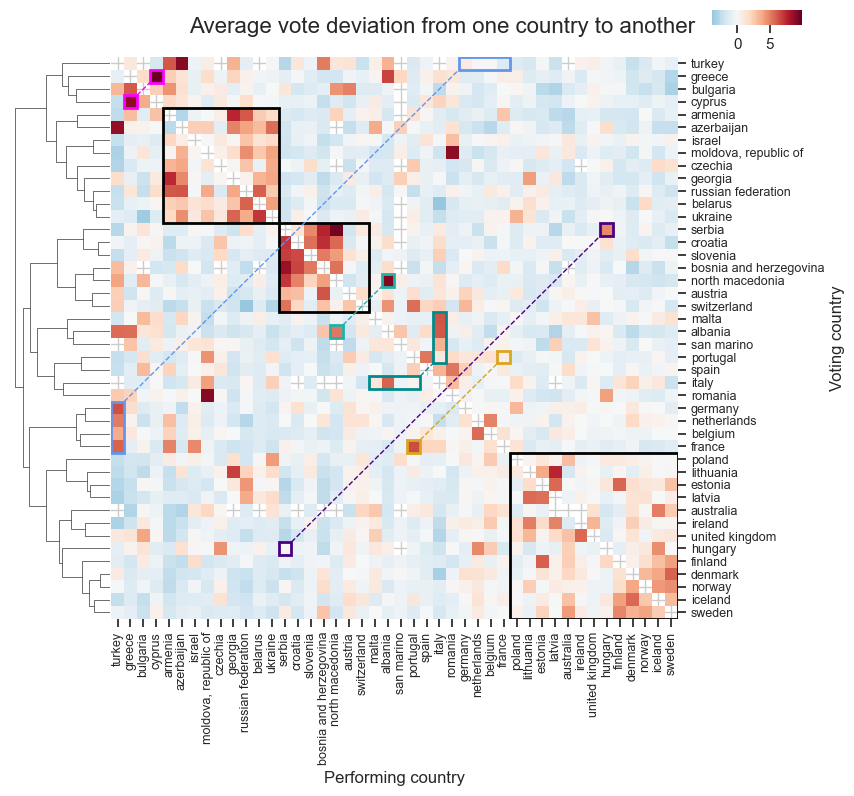

In [26]:
#| code-fold: true
plot = plot_voting_heatmap(df_voting_deviation, cmap='RdBu_r',
                           suptitle='Average vote deviation from one country to another',
                           center=0)

from matplotlib.patches import Rectangle

# Plot a box around the given entries, as specified by indices
def highlight(xmin, ymin, dx, dy, color):
    plot.ax_heatmap.add_patch(Rectangle((xmin, ymin), dx, dy, fill=False, edgecolor=color, linewidth=2))
    # Plot the reverse as well, plus a connecting line, if the box is not symmetric about the diagonal
    if xmin != ymin or dx != dy:
        plot.ax_heatmap.add_patch(Rectangle((ymin, xmin), dy, dx, fill=False, edgecolor=color, linewidth=2))
        plot.ax_heatmap.plot([xmin+dx, ymin], [ymin, xmin+dx], color=color, linewidth=1, linestyle='--')

highlight(4, 4, 9, 9, 'black')                # ex-Soviet
highlight(31, 31, 13, 13, 'black')            # Baltics
highlight(13, 13, 7, 7, 'black')              # Balkans

highlight(0, 27, 1, 4, 'cornflowerblue')      # Turkey to Germany, the Netherlands, Belgium, France
highlight(20, 25, 4, 1, 'darkcyan')           # Italy to Malta, San Marino, Albania, Portugal
highlight(13, 38, 1, 1, 'indigo')             # Serbia to Hungary
highlight(17, 21, 1, 1, 'lightseagreen')      # North Macedonia to Albania
highlight(23, 30, 1, 1, 'goldenrod')          # Portugal to France
highlight(1, 3, 1, 1, 'fuchsia')              # Greece to Cyprus

plt.show()

Here, the colorscheme chosen assigns blue to negative deviations (i.e. a voting country gives lower-than-average votes to a performing country), and red to positive deviations.

There do not appear to be any significant *negative* deviations.
However, there are a number of interesting regions with positive deviations, which are highlighted by additional coloured boxes.
For example:

- The small blue boxes on the left indicate that Turkey's entries have consistently obtained higher-than-average scores from Germany, the Netherlands, Belgium, and France; but that this isn't reciprocated, as the other blue box on the top shows.
  A possible hypothesis for this may be the fact that there is a significant Turkish diaspora in these countries; this reinforces our decision to include migration statistics in our collated dataset.

- The large black boxes along the diagonal show clusters of countries who vote highly for each other and tend to be closer geographically.
  For example, the cluster in the bottom-right contains many Nordic countries, the box in the centre Balkan countries, and the top-left box ex-Soviet countries.
  Overall, this suggests that sharing a border and and other geopolitical relationships may influence how countries vote.

## Voting Pair Plots

We can also look at these inter-country relationships using scatter plots.
In the following plots, each point is an average voting score from one country to another.

In [27]:
#| code-fold: true
pair_grouped_points = df.groupby(['to_country', 'from_country'])['points']

votes = (df.loc[:, ['to_country', 'from_country', 'points', 'year']]
            .assign(
                # Number of times the country performed in Eurovision finals
                times_competed=lambda x: x.groupby(['to_country'])['year'].transform('nunique'),
                # The total number of points country A has given to country B, across all years
                total_points=pair_grouped_points.transform('sum'),
                # The number of times country A has given (nonzero) points to country B, across all years
                times_voted=pair_grouped_points.transform(lambda x: x[x > 0].count()),
                # The average number of points country A has given to country B, across all years
                average_points=pair_grouped_points.transform('mean'),
                # The average number of points country B has gotten, across all voting countries and all years
                overall_average_points=lambda x: x.groupby(['to_country'])['points'].transform('mean'),
                # The deviation from the average points given by country A to country B
                vote_deviation=lambda x: x['average_points'] - x['overall_average_points'])
            .loc[:, ['to_country', 'from_country', 'times_competed', 'times_voted', 'total_points', 'average_points', 'overall_average_points', 'vote_deviation']]
            .drop_duplicates(subset=['to_country', 'from_country'])
            .sort_values(by=['to_country', 'from_country'])
            .reset_index(drop=True)
)
votes.head()

to_country from_country  times_competed  times_voted  total_points  \
0    albania      andorra              10            0             0   
1    albania      armenia              10            0             0   
2    albania    australia              10            0             0   
3    albania      austria              10            4            22   
4    albania   azerbaijan              10            3            12   

   average_points  overall_average_points  vote_deviation  
0        0.000000                1.738579       -1.738579  
1        0.000000                1.738579       -1.738579  
2        0.000000                1.738579       -1.738579  
3        3.142857                1.738579        1.404278  
4        1.500000                1.738579       -0.238579

The following is an *interactive* scatter plot, which will allow you to better explore the data yourself.
Each data point represents one performer–voter pair; hovering over it will show specific information about each pair.

The *x*-axis represents the total number of points which the voter has given the performer over the timeframe of our analysis, and the *y*-axis the average.
Thus, for example, the upper-left corner contains country pairs which have not voted many times (leading to a small total), but with a large average (meaning that very high scores have been given on average).
The top-leftmost point reveals that Serbia 🇷🇸 has only voted for Montenegro 🇲🇪 once, but gave them 12 points, the highest possible score.

In [28]:
#| code-fold: true
import plotly.express as px

fig = px.scatter(votes, x='total_points', y='average_points')
fig.update_traces(hovertemplate=('Performer: %{customdata[0]}'
                                 '<br>Voter: %{customdata[1]}'
                                 '<br>Total Eurovisions competed: %{customdata[2]}'
                                 '<br>Total times voted for by selected country: %{customdata[3]}'
                                 '<br>Total points given: %{customdata[4]}'
                                 '<br>Average points: %{customdata[5]:.2f}'),
                  customdata=votes,
                  marker={'color': 'rgba(50, 50, 150, 0.1)', 'opacity': 0.5, 'size': 6,
                          'line': {'color': 'rgba(50, 50, 150, 1.0)', 'width': 1}})
fig.update_layout(hoverlabel_align='left', width=640, height=640, margin=dict(l=20, r=20, t=20, b=20),
                  xaxis={'title': 'Total points given by one country to another'},
                  yaxis={'title': 'Average points given by one country to another'})
fig.show()

Alternatively, we can visualise the vote deviations for each performer–voter pair as we did above.
We reuse the same colour scheme here, with red implying a strong positive preference (i.e. a country that consistently gave higher-than-average votes to another) and blue indicating a negative preference.

In [29]:
#| code-fold: true
votes = (votes.assign(highest_average_point=lambda x: x.groupby(['to_country'])['average_points'].transform('max'))
              .sort_values(by='highest_average_point', ascending=True))

fig = px.scatter(votes, x='average_points', y='to_country', color='vote_deviation', 
                 color_continuous_scale=px.colors.diverging.RdBu_r,
                 color_continuous_midpoint=0)
fig.update_traces(hovertemplate=('Performer: %{customdata[0]}'
                                 '<br>Voter: %{customdata[1]}'
                                 '<br>Total Eurovisions competed: %{customdata[2]}'
                                 '<br>Total times voted for by selected country: %{customdata[3]}'
                                 '<br>Total points given: %{customdata[4]}'
                                 '<br>Average points overall: %{customdata[7]:.2f}'),
                  customdata=votes)
fig.update_layout(hoverlabel_align='left', width=640, height=640, margin=dict(l=20, r=20, t=20, b=20),
                  xaxis={'title': 'Average points received from each voter'},
                  yaxis={'title': 'Performing country'}, 
                  coloraxis_colorbar=dict(title='Deviation from average points'))

fig.update_yaxes(tickfont_size=8)
fig.show()

## Exploring Country Friendships, Biases, and One-sided Relationships

After looking at the broader patterns above, let's now dive into some specific country-pairs. 
We will look for the top country pairs which
* give each other very high scores
* give each other very low scores
* have a one-sided relationship, where one country gives high scores to another, but receives low scores back.

First, we'll filter out countries which haven't participated frequently enough, to ensure that our average voting score is a robust estimate.

In [30]:
#| code-fold: true
# how often did each country participate?
n_participations = (df
                    .groupby('to_country')['year']
                    .nunique()
                    .sort_values(ascending=True))
# filter countries with less than 5 participations
countries_to_remove = n_participations[n_participations < 5].index.tolist()
# remove from df
df_pairs = df[~df['to_country'].isin(countries_to_remove)]
# get random 5 rows from df_pairs
# df_pairs.sample(5)

To look at more specific relationships, we'll calculate for each country pair how much their average votes for each differ. This value would be small if they both tend to give each other high or low scores, but it would be large if one country gives the other high scores, but gets low scores back. To check whether this worked, we have a look at the top five country pairs that give each other high votes.

In [31]:
#| code-fold: true
# Grouping by performer and voter, calculate mean votes and count number of years
df_pairs = (df_pairs
    .groupby(['from_country', 'to_country'])
    .agg(votes = ('points', 'mean'), num_years = ('year', 'count'))
    .reset_index()
    .sort_values('votes', ascending=False)
)

# Merge original dataframe with its reverse
df_pairs = (df_pairs
    .merge(df_pairs.rename(columns={'from_country': 'to_country', 
                               'to_country': 'from_country'}), 
           on=['from_country', 'to_country'])
    .drop_duplicates()
    .query('from_country != to_country')
    .assign(votes_diff = lambda x: abs(x['votes_x'] - x['votes_y']))
    .reindex(columns=['from_country', 'to_country', 'num_years', 'votes_x', 'votes_y', 'votes_diff'])
)

# create combined column with pairs in alphabetical order
df_pairs['country_pair'] = df_pairs[['from_country', 'to_country']].apply(lambda x: ' - '.join(sorted(x)), axis=1)
# Remove duplicate country pairs and the temporary country_pair column
df_pairs = (df_pairs
            .drop_duplicates(subset=['country_pair'])
            .drop(columns=['country_pair']))

df_pairs.head()

from_country            to_country  num_years    votes_x  \
0              azerbaijan                turkey        NaN  12.000000   
2                  cyprus                greece        NaN  11.777778   
4                 romania  moldova, republic of        NaN  11.500000   
5                  serbia       north macedonia        NaN  11.333333   
6  bosnia and herzegovina                serbia        NaN  11.333333   

     votes_y  votes_diff  
0  12.000000    0.000000  
2  11.692308    0.085470  
4  10.923077    0.576923  
5   9.909091    1.424242  
6  10.166667    1.166667

To prepare the data for plotting, we filter for the top five country pairs that give each other high, low and unequal votes.

In [32]:
#| code-fold: true
# Number of country pairs to show for each category
N = 5

# top 5 country pairs with high votes for each other
top_highs = (df_pairs
    .query('votes_diff < 3')
    .sort_values('votes_x', ascending=False).head(N)
)

# top 5 country pairs with low votes for each other
top_lows = (df_pairs
    .query('votes_diff < 3')
    .sort_values('votes_x', ascending=True).head(N)
)

# top 5 unbalanced country pairs (one gives high votes to the other, but gets low votes back)
top_one_sided = (df_pairs
            .sort_values('votes_diff', ascending=False).head(N))

# combine 
top_relationships = (pd.concat([top_highs, top_lows, top_one_sided]))
# add grouping
top_relationships['group'] = ['high'] * N + ['low'] * N + ['one-sided'] * N

# sort by votes_x
top_relationships = top_relationships.sort_values('votes_x')

top_relationships['y'] = range(1, len(top_relationships) + 1)

top_relationships

from_country            to_country  num_years    votes_x  \
1662                   italy                turkey        NaN   0.000000   
1632                 romania               georgia        NaN   0.000000   
1620                 albania             lithuania        NaN   0.090909   
1621                 armenia            azerbaijan        NaN   0.090909   
1612                 belarus               ireland        NaN   0.125000   
32                    turkey               armenia        NaN   8.800000   
26                    france                turkey        NaN   9.142857   
21                   germany                turkey        NaN   9.642857   
16                 australia               ireland        NaN  10.000000   
9                      malta                 italy        NaN  10.545455   
5                     serbia       north macedonia        NaN  11.333333   
6     bosnia and herzegovina                serbia        NaN  11.333333   
4                    romania  moldova, republic of        NaN  11.500000   
2                     cyprus                greece        NaN  11.777778   
0                 azerbaijan                turkey        NaN  12.000000   

        votes_y  votes_diff      group   y  
1662   0.000000    0.000000        low   1  
1632   0.000000    0.000000        low   2  
1620   0.000000    0.090909        low   3  
1621   0.000000    0.090909        low   4  
1612   0.000000    0.125000        low   5  
32     0.800000    8.000000  one-sided   6  
26     0.200000    8.942857  one-sided   7  
21     2.466667    7.176190  one-sided   8  
16     2.166667    7.833333  one-sided   9  
9      3.500000    7.045455  one-sided  10  
5      9.909091    1.424242       high  11  
6     10.166667    1.166667       high  12  
4     10.923077    0.576923       high  13  
2     11.692308    0.085470       high  14  
0     12.000000    0.000000       high  15

In [33]:
#| code-fold: true
# Replace group names with numeric values for sorting
group_order = {'low': 1, 'one-sided': 2, 'high': 3}
top_relationships['group_order'] = top_relationships['group'].replace(group_order)

# Create a new column representing the minimum value between 'votes_x' and 'votes_y'
top_relationships['min_votes'] = top_relationships[['votes_x', 'votes_y']].min(axis=1)

# Sort the DataFrame by 'group_order' and 'min_votes'
top_relationships = top_relationships.sort_values(by=['group_order', 'min_votes'], ascending=[True, True])

# Reassign the 'y' column after sorting
top_relationships['y'] = range(1, len(top_relationships) + 1)

Let's plot the results!

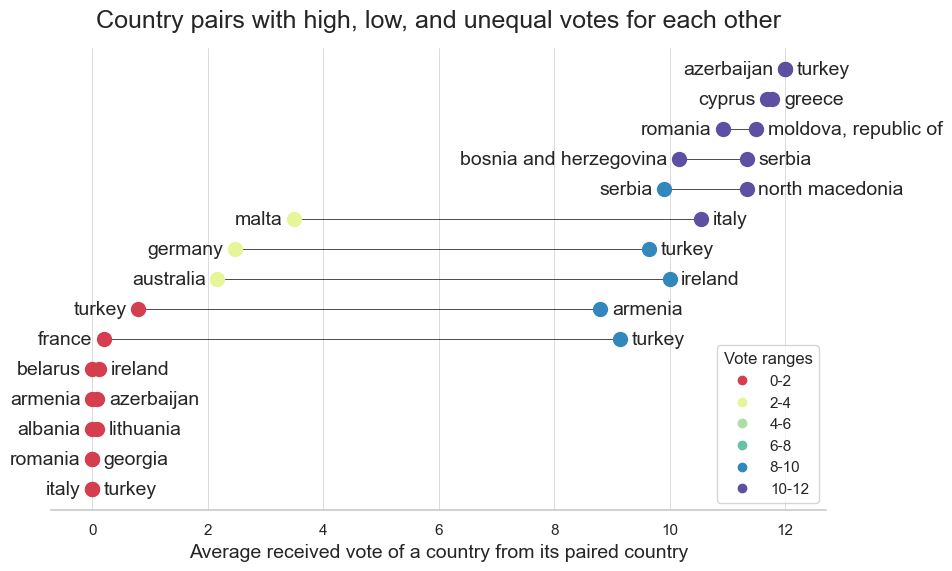

In [34]:
#| code-fold: true
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(axis='x', linestyle='-', linewidth=0.5)

# create a color map with 6 colors from red to blue
colors = sns.color_palette("YlOrRd", 6)[::-1]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=len(colors))

# get color map with viridis colors for 6 bins
cmap = plt.get_cmap('viridis' )

#colors = ["#b2182b", "#d1e5f0", "#92c5de", "#4393c3", "#2166ac", "#053061" ]
colors = ["#d53e4f", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=len(colors))


# define the range boundaries
bins = np.arange(0, 13, 2)

# add text labels and points
for i, row in top_relationships.iterrows():
    ax.text(row['votes_x']+0.2, row['y'] ,row['to_country'],  ha='left', va='center', fontsize=14)  # increase the value added to 'votes_x' for more space
    ax.text(row['votes_y']-0.2, row['y'] , row['from_country'],  ha='right', va='center', fontsize=14)  # increase the value subtracted from 'votes_y' for more space

    # plot points with colors based on x-value range
    x_color = np.digitize(row['votes_x'], bins=bins, right=True)-1
    y_color = np.digitize(row['votes_y'], bins=bins, right=True)-1
    ax.scatter(row['votes_x'], row['y'], color=cmap(x_color/6), s=100, alpha=1, zorder=3)
    ax.scatter(row['votes_y'], row['y'], color=cmap(y_color/6), s=100, alpha=1, zorder=3)

    # add line between countries with slightly shortened length
    line_buffer = 0.1
    ax.plot([row['votes_x'] + line_buffer, row['votes_y'] - line_buffer], [row['y'], row['y']], color='black', alpha=0.7, zorder=2, linewidth=0.7)

ax.set_xlabel('Average received vote of a country from its paired country', fontsize=14)
ax.set_ylabel('')

# Hide the y axis
ax.get_yaxis().set_visible(False)
ax.spines[['top', 'right', 'left']].set_visible(False)

# Add legend
markers = [plt.Line2D([0,0],[0,0], color=cmap(i/6), marker='o', linestyle='') for i in range(6)]
plt.legend(markers, ['{}-{}'.format(i, i+2) for i in bins[:-1]], numpoints=1, loc='lower right', title='Vote ranges')

plt.title('Country pairs with high, low, and unequal votes for each other', fontsize=18,  loc='center', pad=15)

plt.show()

The figure shows the top five country pairs which give each other high, low and unequal scores.
The point next to a country name is the score it *received* from the other country. For example, in line with the previous figures, both France 🇫🇷 and Germany 🇩🇪 on average receive low scores from Turkey 🇹🇷, but vote highly for Turkey.
Cyprus 🇨🇾  and Greece 🇬🇷  give each other high scores, and Albania 🇦🇱 and Lithuania 🇱🇹 tend to give each other low scores.

The plot differs a bit from the results above, because it is looking at raw votes, not deviations from the mean vote.
Therefore, one-sided voting does not necessarily indicate bias in voting: it may simply be because the country has historically performed very well (or very poorly!) in the Eurovision Song Contest.

# Migration Data

 **TODO** Maybe plot prop_emigrants versus the score deviation?

One of our main goals was to predict the winner of the 2023 contest. On a finer scale, this means predicting how each country will vote for each other country. Arguably, countries with a large immigrant population from another country might give more favorable votes to that country. To test and incorporate this in our models, we used migration data from [Our World in Data](https://ourworldindata.org/migration). Specifically, we were interested in the proportion of immigrants in each country from each other country. We calculated both sides, i.e. proportion emigrants from the voter country in the perfomer country (v2p) and the other way round.

In [35]:
# migration data
df.filter(like='migr').head()

migration_v2p  prop_emigrants_v2p  migration_p2v  prop_emigrants_p2v  \
0          205.0            0.000044           72.0            0.000007   
1           92.0            0.000107           77.0            0.000008   
2            0.0            0.000000           57.0            0.000006   
3            NaN                 NaN          120.0            0.000012   
4          144.0            0.000028         1541.0            0.000152   

   migration_pop_year  
0              1995.0  
1              1995.0  
2              1995.0  
3              1995.0  
4              1995.0

In [36]:
#| code-fold: true
df_migration = df[['year', 'from_code2', 'to_code2', 'prop_emigrants_v2p', 'prop_emigrants_p2v', 'points']].copy()

# Calculate score deviation per year
df_migration['avg_votes'] = df_migration.groupby(['to_code2', 'year'])['points'].transform('mean')
df_migration['deviation'] = df_migration['points'] - df_migration['avg_votes']


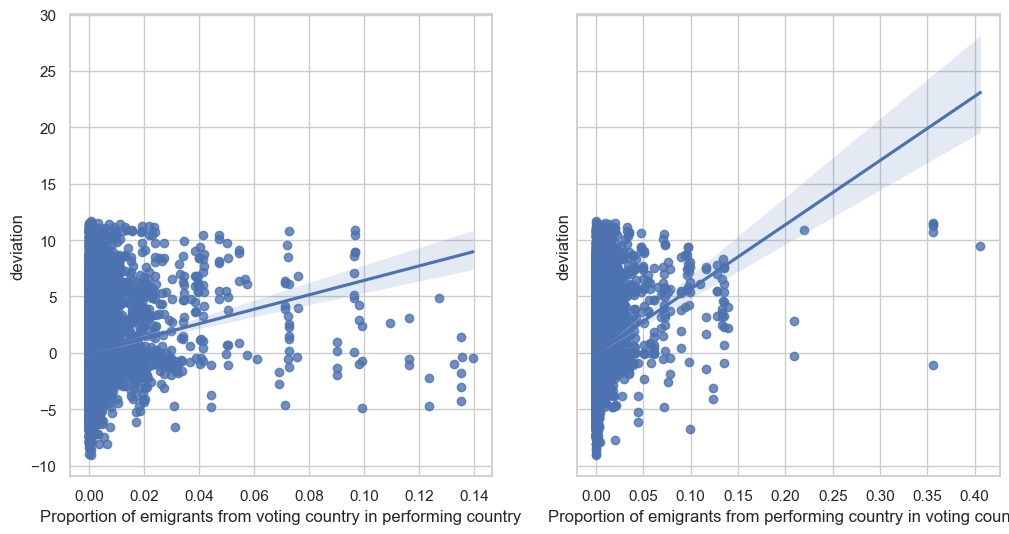

In [37]:
#| code-fold: true
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))
sns.regplot(x='prop_emigrants_v2p', y='deviation', data=df_migration, ax=ax1)
sns.regplot(x='prop_emigrants_p2v', y='deviation', data=df_migration, ax=ax2)

ax1.set_xlabel('Proportion of emigrants from voting country in performing country')
ax2.set_xlabel('Proportion of emigrants from performing country in voting country')

plt.show()

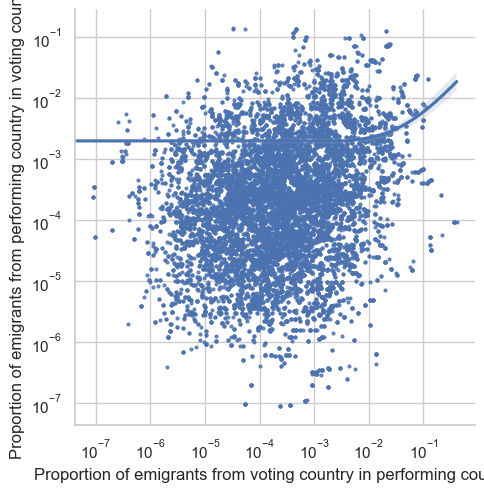

In [38]:
#| code-fold: true
sns.lmplot(x='prop_emigrants_p2v', y='prop_emigrants_v2p', data=df_migration, scatter_kws={"s": 4})

# log scale axes
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Proportion of emigrants from voting country in performing country")
plt.ylabel("Proportion of emigrants from performing country in voting country")
plt.show()

# Language Data

We are interested in three things:
1. Does the song contain english lyrics: yes vs no &#x2705;
2. What are the average votes for songs with english lyrics vs non-english lyrics &#x2705;
3. Does the performer sing in their official language yes vs no (english) vs no (non-english) &#x2705;
4. How many languages appear in the song vs votes? (can you hedge your bets?) &#x2705;
5. Are the votes received affected by whether or not a song is sung in the voting country's official language? &#x2705;

**TODO** Get language data cleaned up, see https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/issue-5-exploratory_visualisations/eurovision/notebooks/language_visualistaions.ipynb.

**TODO** Discussion of Eurovision language rules (this has changed over time).

In this dataset, we have categorised the song language into one or more of: the country's official language (`own`), English (`eng`), or an entirely separate language (`other`).
When English *is* one of the country's official languages, both `own` and `other` are selected.
We can use this data to investigate how likely each country is to perform in English:

In [39]:
#| code-fold: true
df_performance = df[['year', 'Artist', 'to_country', 
       'total_points', 
       'rank', 'to_code2',
       'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender']].drop_duplicates()

In [40]:
df_performance.loc[df_performance['year'] == 2018]['to_country'].value_counts()

australia               1
austria                 1
united kingdom          1
ukraine                 1
sweden                  1
spain                   1
slovenia                1
serbia                  1
portugal                1
norway                  1
netherlands             1
moldova, republic of    1
lithuania               1
italy                   1
israel                  1
ireland                 1
hungary                 1
germany                 1
france                  1
finland                 1
estonia                 1
denmark                 1
czechia                 1
cyprus                  1
bulgaria                1
albania                 1
Name: to_country, dtype: int64

In [41]:
#| code-fold: true
# get the percentage of performances who contain own language
print('Percentage of performances in own language:', round(sum(df_performance['Contains_Own_Language'])/len(df_performance) *100), '%')
print('Percentage of performances in English:', round(sum(df_performance['Contains_English'])/len(df_performance) *100), '%')

print('Percentage of performances by gender:')
df_performance['gender'].value_counts()/len(df_performance) * 100

Percentage of performances in own language: 46 %
Percentage of performances in English: 76 %
Percentage of performances by gender:


female    40.000000
male      30.333333
group     29.666667
Name: gender, dtype: float64

In [42]:
#| code-fold: true
df_language = df_performance.copy()

df_performance['English_only'] = (df_performance['Contains_English']) & (df_performance['Number_of_Languages'] == 1 )
df_performance['No_English'] = ~df_performance['Contains_English'] 
df_performance['Some_English'] = (df_performance['Contains_English']) & (df_performance['Number_of_Languages'] > 1 )

# for each country get the ratio of songs that contain only English, some English and no English
# then sort by the ratio of songs that contain only English
df_language = df_performance.groupby('to_country').agg({'English_only': 'mean', 'Some_English': 'mean', 'No_English': 'mean'})

df_language = df_language.sort_values(by=['English_only', 'Some_English'], ascending=True)

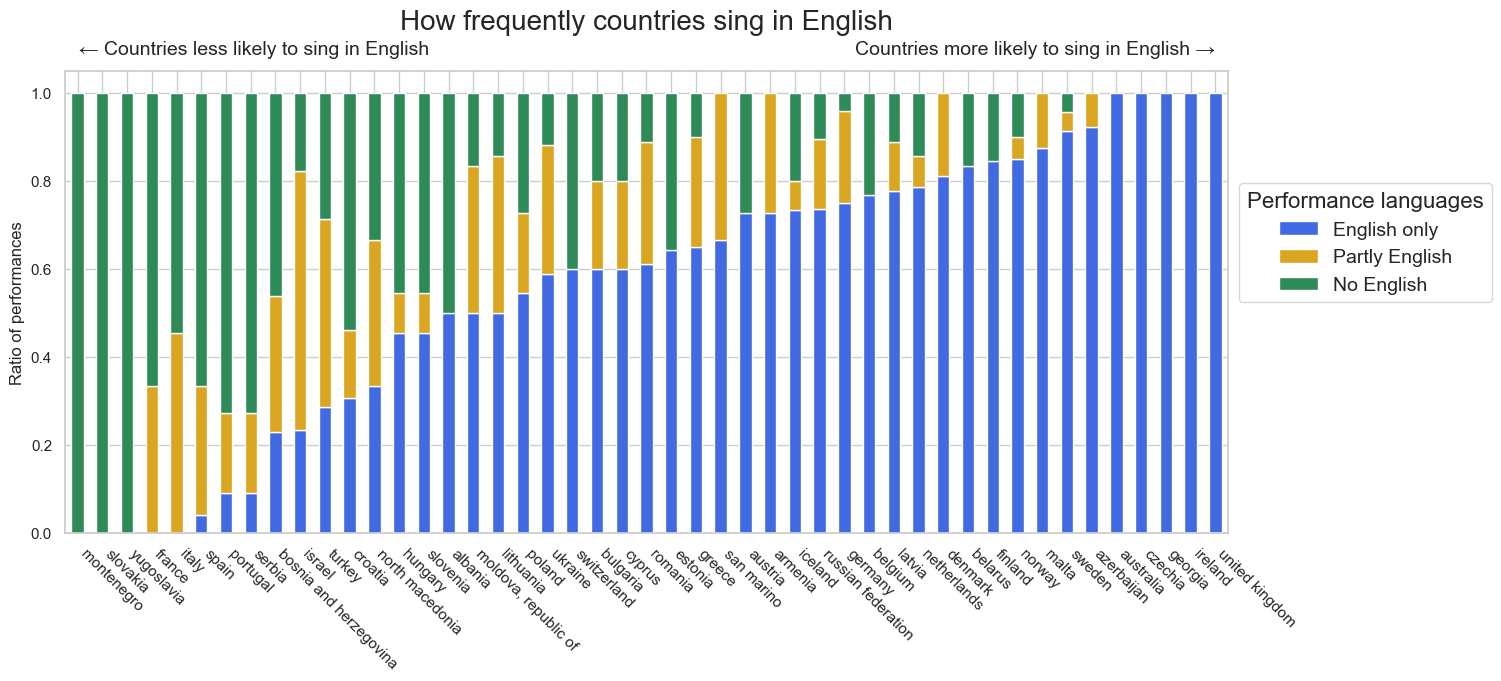

In [43]:
#| code-fold: true
colours = {"English_only":'royalblue', "No_English":'seagreen', "Some_English":'goldenrod'}

df_language.plot(kind='bar', figsize=(15, 6), stacked=True, color=colours)

plt.legend(['English only', 'Partly English', 'No English'], title="Performance languages", loc=[1, 1], 
        fontsize=14,  bbox_to_anchor=(0.51, 0., 0.5, 0.5), title_fontsize=16)

plt.title('How frequently countries sing in English', fontsize=20, pad=30)

plt.text(df_language.shape[0]-1, 1.1, 'Countries more likely to sing in English →', ha='right', va='center', fontsize=14)
plt.text(0.05, 1.1, '← Countries less likely to sing in English ', ha='left', va='center',  fontsize=14)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

plt.show()

In [44]:
#| code-fold: true
# convert wide to long format
df_long = df_performance[['English_only', 'No_English',	'Some_English', 'total_points']]

df_long = df_long.melt(id_vars=['total_points'], var_name='language', value_name='contains_language')

df_long['contains_language'] = df_long['contains_language'].astype(int)

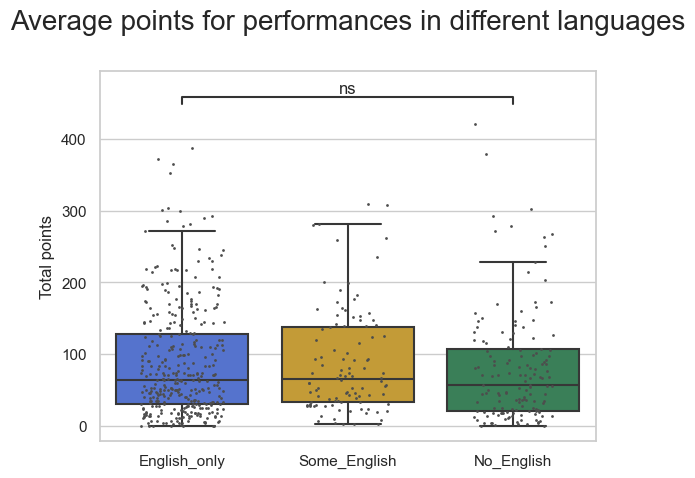

In [45]:
#| code-fold: true
import scipy.stats as stats
from statannot import add_stat_annotation

# boxplots for each language type
ax = sns.boxplot(x='language', y='total_points', 
    data=df_long.loc[df_long['contains_language'] > 0], 
    palette=colours, showfliers=False, 
    order=['English_only', 'Some_English', 'No_English'])
sns.stripplot(x='language', y='total_points', 
    order=['English_only', 'Some_English', 'No_English'],
    data=df_long.loc[df_long['contains_language'] > 0], 
    jitter=0.25, size=2, color=".3", linewidth=0)

plt.title('Average points for performances in different languages', fontsize=20, pad=30)
plt.xlabel('')
plt.ylabel('Total points')

add_stat_annotation(ax, data=df_long.loc[df_long['contains_language'] > 0],
                    x='language', y='total_points', 
                    order=['English_only', 'Some_English', 'No_English'],
                    box_pairs=[("English_only", "No_English")],
                    test='Mann-Whitney', text_format='star', verbose=0)

plt.show()

In [46]:
#| code-fold: true
df_language = df_performance.copy()

df_performance['Own_language'] = (df_performance['Contains_Own_Language']) 
df_performance['Other_language'] = ~df_performance['Contains_Own_Language'] 

# for each country get the ratio of songs that contain only English, some English and no English
# then sort by the ratio of songs that contain only English
df_language = df_performance.groupby('to_country').agg({'Other_language': 'mean', 'Own_language': 'mean'})

df_language = df_language.sort_values(by=['Own_language', 'Other_language'], ascending=True)

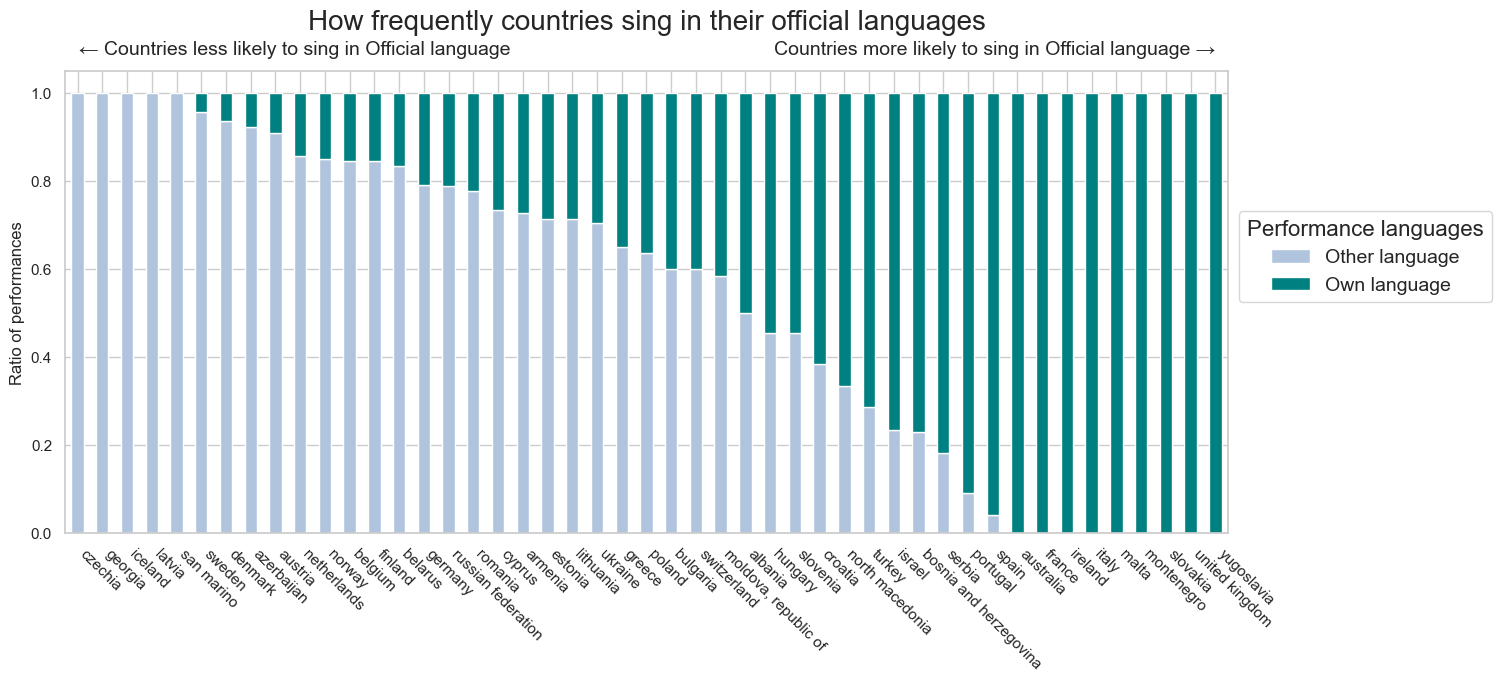

In [47]:
#| code-fold: true
colours = {"Own_language":'teal', "Other_language":'lightsteelblue'}

df_language.plot(kind='bar', figsize=(15, 6), stacked=True, color=colours)

plt.legend(['Other language', 'Own language'], title="Performance languages", loc=[1, 1], 
        fontsize=14,  bbox_to_anchor=(0.51, 0., 0.5, 0.5), title_fontsize=16)

plt.title('How frequently countries sing in their official languages', fontsize=20, pad=30)

plt.text(df_language.shape[0]-1, 1.1, 'Countries more likely to sing in Official language →', ha='right', va='center', fontsize=14)
plt.text(0.05, 1.1, '← Countries less likely to sing in Official language ', ha='left', va='center',  fontsize=14)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

plt.show()

Typically those on the left of this plot are countries who sing in english but english is not their official language. Those on the right are countries who sing in their official language exclusively.

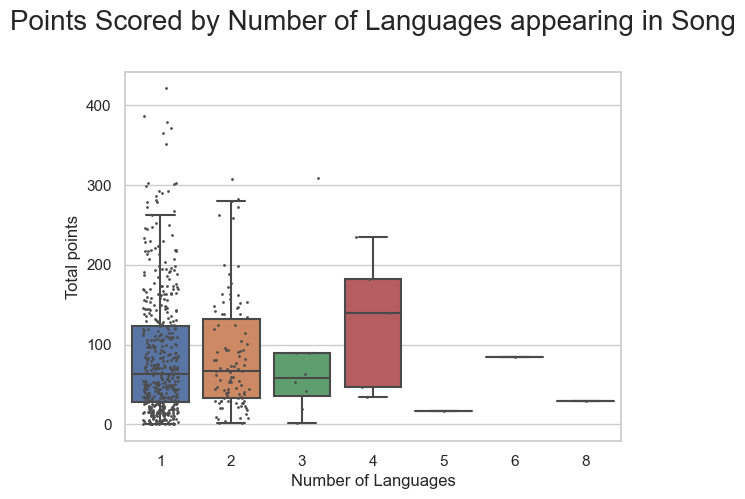

In [48]:
#| code-fold: true
sns.boxplot(x='Number_of_Languages', y='total_points', data=df_performance, showfliers=False)
sns.stripplot(x='Number_of_Languages', y='total_points', data=df_performance, jitter=0.25, size=2, color=".3", linewidth=0)

plt.title('Points Scored by Number of Languages appearing in Song', fontsize=20, pad=30)
plt.xlabel('Number of Languages')
plt.ylabel('Total points')


plt.show()

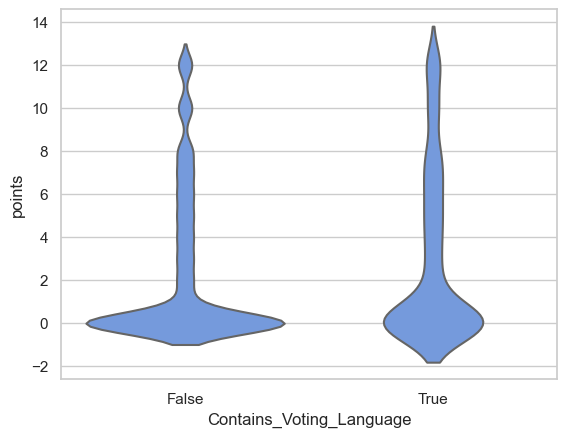

In [49]:
#| code-fold: true
# violin plot
sns.violinplot(x='Contains_Voting_Language', y='points', data=df, inner=None, color="cornflowerblue")

plt.show()

# Gender Data

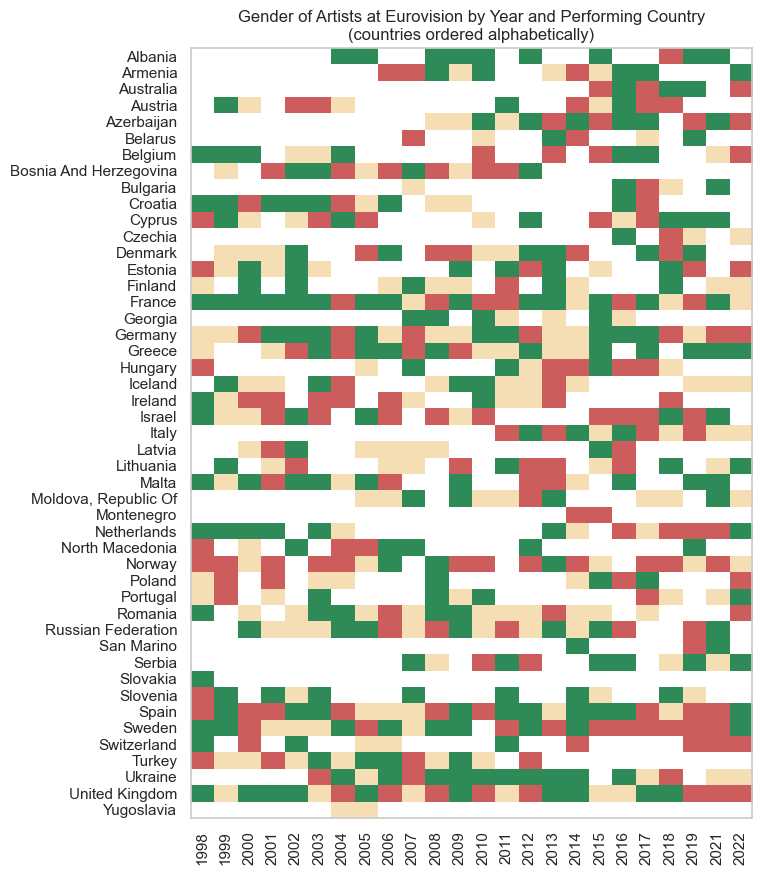

In [50]:
#| code-fold: true
from matplotlib.colors import to_rgba

gender_df = df[['year', 'to_country', 'gender']].copy().drop_duplicates()

countries = gender_df.sort_values(by=['to_country'])['to_country'].drop_duplicates().to_list()
years = gender_df['year'].drop_duplicates().to_list()

gender_colours = {
    'female': to_rgba('seagreen'),
    'group': to_rgba('wheat'),
    'male': to_rgba('indianred'),
    'none': to_rgba('white')
}

gender = []
for year in years:
    missing = pd.DataFrame({'year': [year] * len(countries), 'to_country': countries, 'gender': ['none'] * len(countries)}).set_index('to_country')
    missing.update(gender_df[gender_df['year'] == year].set_index('to_country'))
    gender.append(list(map(lambda x: gender_colours[x], missing.sort_values(by=['to_country'])['gender'].to_list())))

gender = list(map(list, zip(*gender)))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
img = plt.imshow(gender, aspect=0.7)
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years)
plt.xticks(rotation=90)
ax.set_yticks(range(len(countries)))
ax.set_yticklabels(list(map(str.title, countries)))
ax.grid(False)
plt.title('Gender of Artists at Eurovision by Year and Performing Country\n(countries ordered alphabetically)')

plt.show()

In [51]:
#| code-fold: true
for gender in ['female', 'male', 'group']:
    count = len(gender_df[gender_df['gender'] == gender])
    print('Total {} performers: {} ({:.0%})'.format(gender, count, count/len(gender_df)))

def ratio(gender, x): return len([a for a in x if a == gender]) / len(x)

gender_df = gender_df.groupby('to_country').agg(
    female=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('female', x)),
    group=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('group', x)),
    male=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('male', x)),
)
gender_df = gender_df.sort_values(by=['female', 'group'], ascending=False)

gender_df.head()

Total female performers: 240 (40%)
Total male performers: 182 (30%)
Total group performers: 178 (30%)


female     group      male
to_country                              
slovakia    1.000000  0.000000  0.000000
albania     0.900000  0.000000  0.100000
san marino  0.666667  0.000000  0.333333
slovenia    0.636364  0.272727  0.090909
ukraine     0.588235  0.235294  0.176471

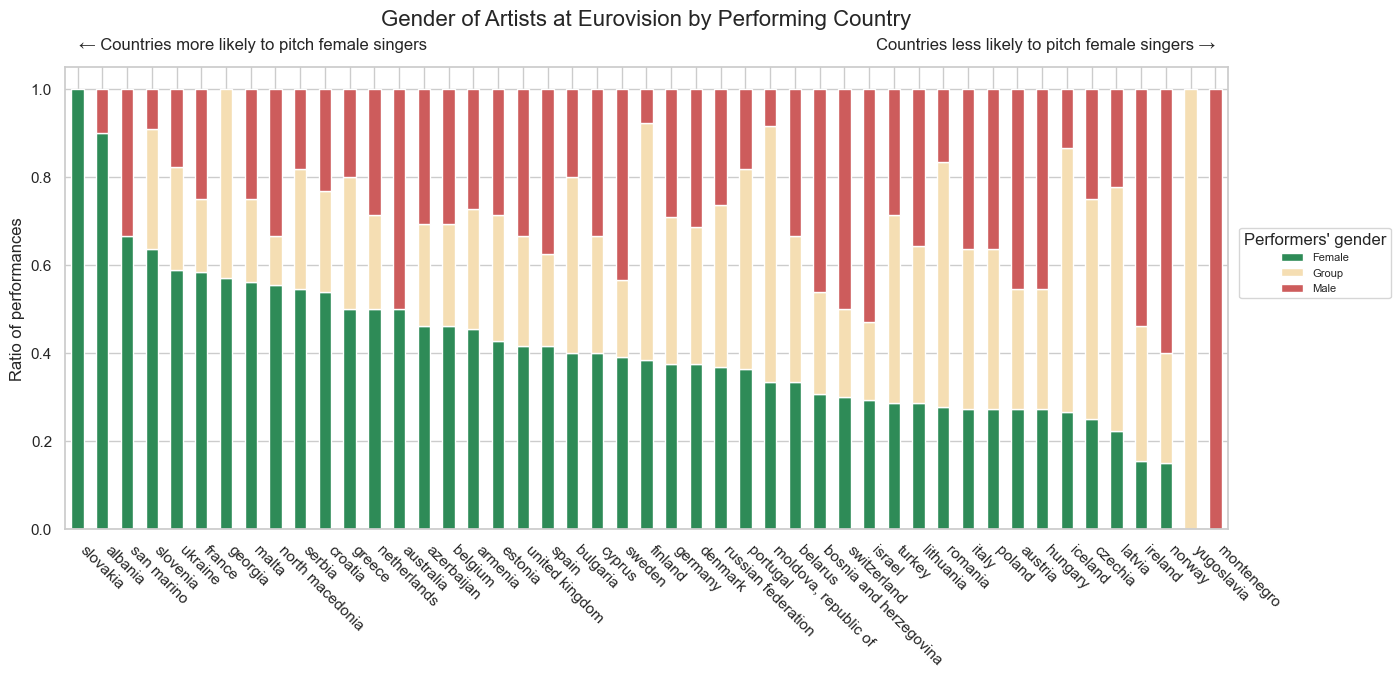

In [52]:
#| code-fold: true
gender_colours = {
    'female': to_rgba('seagreen'),
    'group': to_rgba('wheat'),
    'male': to_rgba('indianred')#,
    #'none': to_rgba('white')
}

gender_df[gender_colours.keys()].plot(kind='bar', figsize=(15, 6), stacked=True, color=gender_colours)
plt.text(gender_df.shape[0] - 1, 1.1, 'Countries less likely to pitch female singers →', ha='right', va='center', fontsize=12)
plt.text(0.05, 1.1, '← Countries more likely to pitch female singers', ha='left', va='center',  fontsize=12)
plt.legend(['Female', 'Group', 'Male'], title="Performers' gender", loc=[1, 1], fontsize=8,  bbox_to_anchor=(0.51, 0., 0.5, 0.5))
plt.title('Gender of Artists at Eurovision by Performing Country', fontsize=16, pad=30)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

plt.show()

In [53]:
#| code-fold: true
gender_df = df[['year', 'to_code2', 'gender']].copy().drop_duplicates()

def ratio(gender, x): return len([a for a in x if a == gender]) / len(x)

gender_df = gender_df.groupby('year').agg(
    female=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('female', x)),
    group=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('group', x)),
    male=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('male', x)),
)

gender_df.head()

female     group      male
year                              
1998  0.480000  0.200000  0.320000
1999  0.478261  0.391304  0.130435
2000  0.333333  0.416667  0.250000
2001  0.260870  0.347826  0.391304
2002  0.583333  0.291667  0.125000

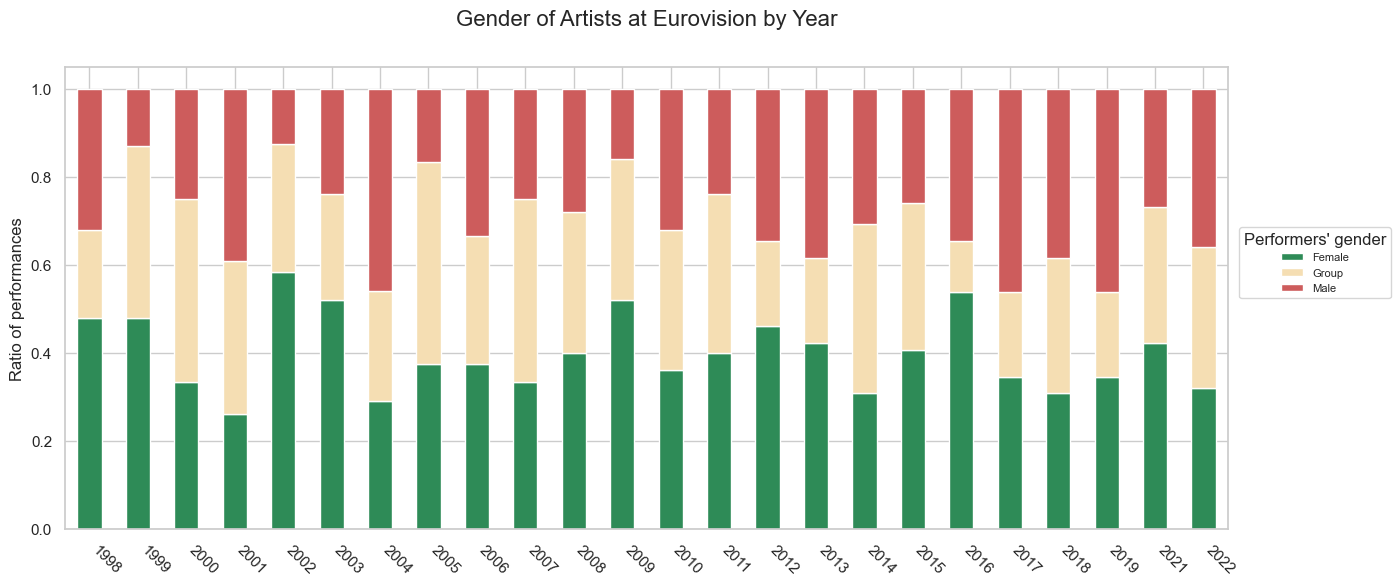

In [54]:
#| code-fold: true
# subset gender_colours to genders in gender_df columns
# gender_colours = gender_colours[gender_df.columns.to_list()]

gender_df.plot(kind='bar', figsize=(15, 6), stacked=True, color=gender_colours)

plt.legend(['Female', 'Group', 'Male'], title="Performers' gender", loc=[1, 1], fontsize=8,  bbox_to_anchor=(0.51, 0., 0.5, 0.5))
plt.title('Gender of Artists at Eurovision by Year', fontsize=16, pad=30)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

plt.show()

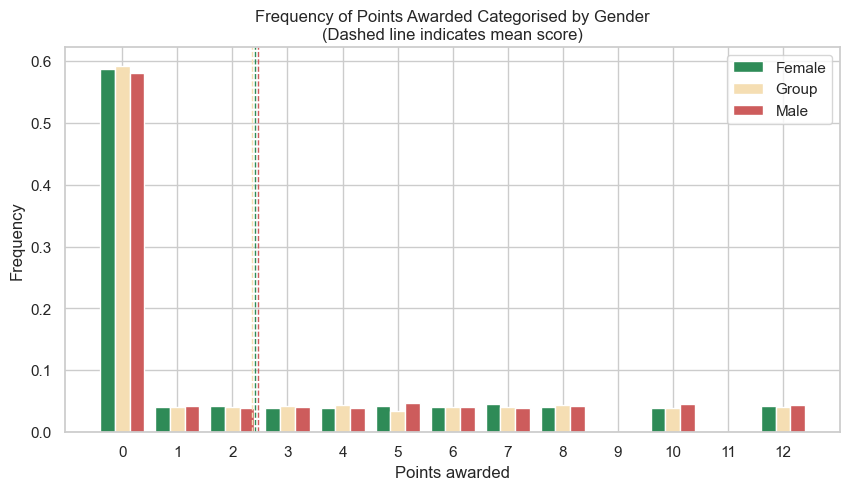

In [55]:
#| code-fold: true
gender_df = df[['year', 'to_code2', 'gender', 'points']].copy()
genders = list(gender_colours.keys())[:3]
votes = []
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
for gender in genders:
    votes_df = gender_df[gender_df['gender'] == gender]['points']
    votes.append(votes_df)
    plt.axvline(votes_df.mean(), color=gender_colours[gender], linestyle='dashed', linewidth=1)

plt.hist(votes, density=True, bins=range(14), color=list(gender_colours.values())[:3], label=[gender.title() for gender in genders], align='left')
plt.xlabel('Points awarded')
plt.ylabel('Frequency')
plt.title('Frequency of Points Awarded Categorised by Gender\n(Dashed line indicates mean score)')
plt.legend()
plt.xticks(range(13))
ax.set_xticklabels([str(i) for i in range(13)])

plt.show()

In [56]:
# TODO: check if male get higher average votes. 

# Collective Visualisations

- Heatmap for correlation plot
- Martin's plot
- Geographical plots
- Scatter plots

In [57]:
#| code-fold: true
df_performance = df[['year', 'Artist', 'to_country', 
       'total_points', 'rank', 'to_code2', 
       'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'prop_emigrants_v2p', 'prop_emigrants_p2v', 'has_border',
       'comps_without_win',
       'Number_of_Languages', 'Contains_Own_Language', 'gender']].drop_duplicates()

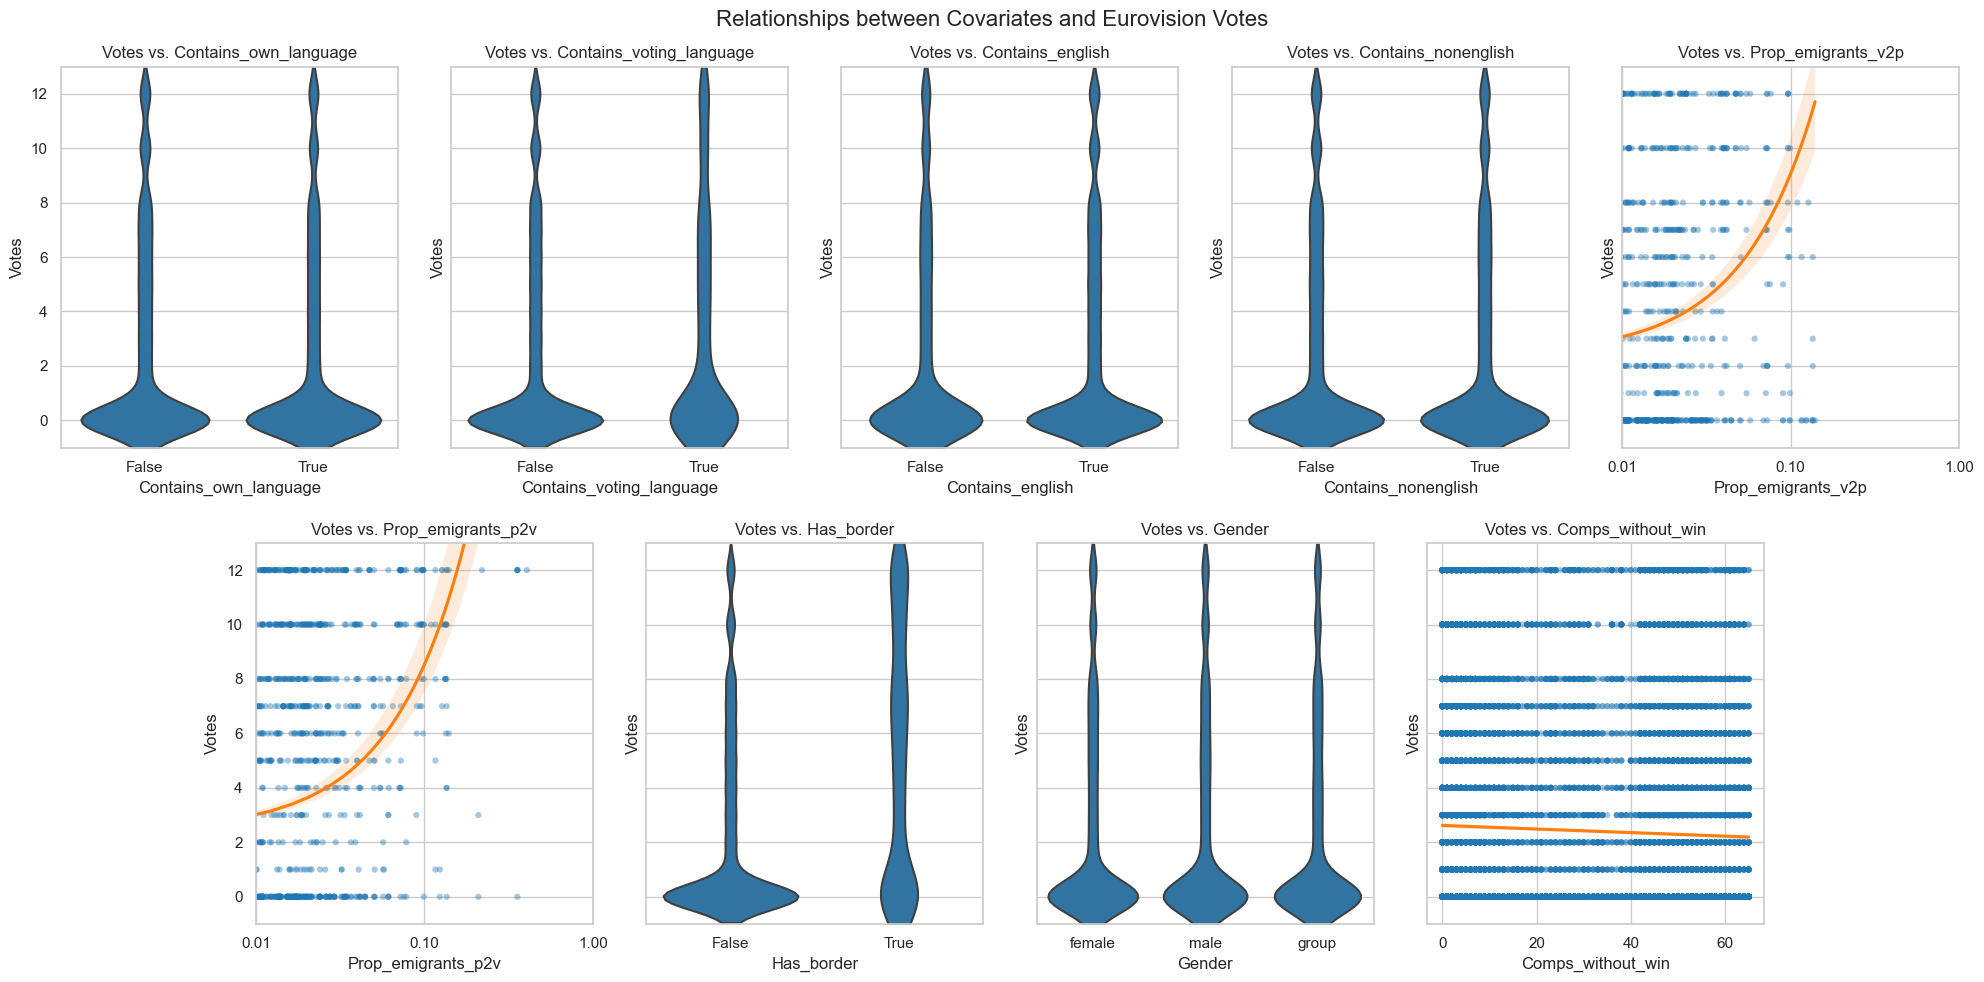

In [58]:
#| code-fold: true
import matplotlib

# Define the variables of interest and their data types
vars_of_interest = {
    'Contains_Own_Language': 'binary',
    'Contains_Voting_Language': 'binary',
    'Contains_English': 'binary',
    'Contains_NonEnglish': 'binary',
    'prop_emigrants_v2p': 'numeric', 
    'prop_emigrants_p2v': 'numeric', 
    'has_border': 'binary',
    'gender': 'categorical', 
    'comps_without_win': 'numeric'
}

# Define the figure and axes
nc = int(np.ceil(len(vars_of_interest)/2))
fig, axes = plt.subplots(nrows=2, ncols=nc, figsize=(20, 10), sharey=True)

# Loop through the dictionary
for i, (key, value) in enumerate(vars_of_interest.items()):
    j, k = 0, i
    if i > (nc - 1):
        j, k = 1, i - nc

    if value == 'categorical':
        sns.violinplot(ax=axes[j, k], x=key, y='points', data=df, color='tab:blue', inner=None, showmeans=True)
    elif value == 'binary':
        sns.violinplot(ax=axes[j, k], x=key, y='points', data=df, color='tab:blue', inner=None, showmeans=True)
    else:
        sns.regplot(ax=axes[j, k], x=key, y='points', data=df, ci=95, 
                    color='tab:blue', scatter_kws={'alpha': 0.4, 'edgecolor': 'none', 's': 20}, 
                    line_kws={'color': 'tab:orange'})

        # if key contains Prop then log scale x axis
        if key.startswith('prop'):
            axes[j, k].set_xscale('log')
            axes[j, k].set_xticks([0.01, 0.1, 1, 10, 100])
            axes[j, k].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            axes[j, k].set_xlim(0.01, 1)

    axes[j, k].set_ylim(-1, 13)
    axes[j, k].set_xlabel(key.capitalize())
    axes[j, k].set_ylabel('Votes')
    axes[j, k].set_title(f'Votes vs. {key.capitalize()}')

fig.suptitle('Relationships between Covariates and Eurovision Votes', fontsize=16)

fig.tight_layout()
fig.subplots_adjust(hspace=0.25)

# Shuffle the bottom row along there are an odd number of variables
if len(vars_of_interest) % 2 == 1:
    axes[1][-1].remove()
    # distance between two axes
    if len(vars_of_interest) >= 3:
        dist = axes[0][1].get_position().x0 - axes[0][0].get_position().x0
        for ax in axes[1]:
            pos = ax.get_position()
            ax.set_position([pos.x0 + (dist / 2), pos.y0, pos.width, pos.height])

plt.show()

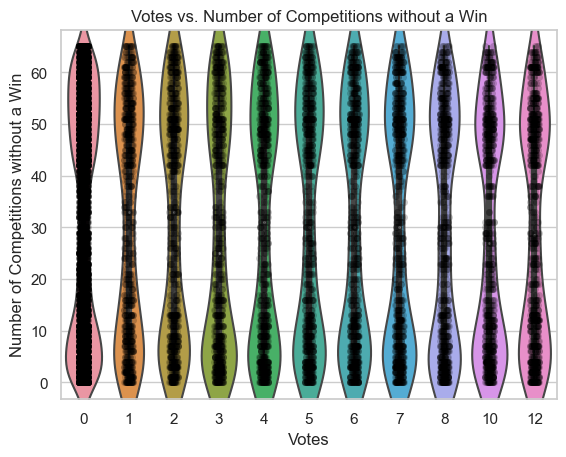

In [59]:
#| code-fold: true
# plot comps_without_win vs. points
sns.violinplot(x='points', y='comps_without_win', data=df)
# add jitter
sns.stripplot(x='points', y='comps_without_win', data=df, jitter=True, color='black', alpha=0.2)

plt.title('Votes vs. Number of Competitions without a Win')
plt.ylabel('Number of Competitions without a Win')
plt.xlabel('Votes')

plt.show()

In [60]:
df[['points', 'comps_without_win']].corr()

points  comps_without_win
points             1.000000          -0.040708
comps_without_win -0.040708           1.000000

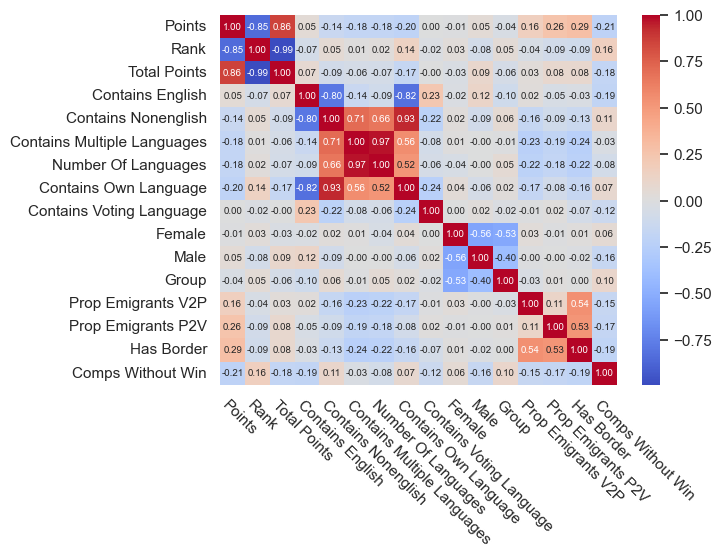

In [61]:
#| code-fold: true
# One hot encoding for the gender variable
df2 = pd.concat([df, pd.get_dummies(df['gender'])], axis=1)

# correlation plot of numeric and binary variables
df_corr = df2[['points', 'rank',
       'total_points', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'Contains_Voting_Language',
       'female', 'male', 'group',
       'prop_emigrants_v2p',  'prop_emigrants_p2v', 'has_border',
       'comps_without_win']].corr()

# heatmap of the correlation matrix
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'fontsize': 7})

# replace _ in labels with space
labels = [label.replace('_', ' ').title() for label in df_corr.columns]
plt.xticks(np.arange(len(labels)), labels, rotation=-45, ha='left', va='top')
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0, va='center')

plt.show()

# Modelling

Having explored all the data we have, we now turn to the question of using it to predict the results for Eurovision 2023.

At the time that we carried out this modelling, Eurovision had not taken place yet. (You will see that the predictions here are *almost* the same as those described in [the Turing's public blog post](https://www.turing.ac.uk/blog/can-data-science-help-us-predict-winner-eurovision-2023), published before the competition!)

However, since the competition has now concluded, we have also performed a retrospective analysis of how well our models performed.

We developed three models: 
1. Baseline Model
2. A Multi-level Bayesian Ordinal Regression Model
3. A Ranked XGBoost Model


We will discuss each of these below and highlight why each was selected, and how their results differ. 

It is a common practice to explore multiple modelling approaches. Different models have different strengths and weaknesses, including how challenging they are to implement, how capable they are at capturing complex structure in the data, and how easy they are to interpret once they have been fitted to the data. 

When selecting potential models, it is crucial to understand the complexity of the problem, as this informs our intuition about how well a model is expected to perform. It's easy to get caught up in the development of an increasingly complex model even when it might be performing no better than a much simpler model.

It is a good idea to start with a simple model, which may be implemented quickly and provide a performance baseline. More complex models developed thereafter would be expected to outperform this baseline if the additional complexity is effective in capturing the patterns in the data.

From this, it follows that there must be a way to evaluate the relative performance of the models: how well they model whats observed in real life. Often, models are evaluated with a process called [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)):
- The available data is split into two datasets: one to fit the model, and the other for testing the model against examples that it has not be exposed to before.
- It is expected that a good model will be able to make accurate predictions on the test data.
- This offers a way to simulate the process of using the model to make predictions about events in the future.

Before looking at three models in more detail, they can be summarised with the following:
- All three models use the votes cast in previous Eurovision competition finals (1998-2022) to fit the parameters of the model.
- All three models may be used to make predictions on how the 2023 competitors will rank in the final.
- The Baseline model only looks at past performance in the competition to make predictions (i.e., it predicts the rank of each country for this year to be the average of its rankings over the past competitions it participated in)
- The Bayesian Regression model and the XGBoost model take in additional information about the performances (e.g., language of the song lyrics) and the countries in the voter-performer pair (e.g., whether they share a land border).
- The two more complex models predict each vote individually, after which the competition ranking may be determined.
- The Bayesian model alone estimates a measure of uncertainty in the fitted model parameters - and hence any predictions generated by the model have an associated uncertainty.

## (1) Baseline model

Arguably the zeroth rule of data science is to *keep it simple*.\*
In other words, if we can capture patterns in the data using a less complicated model, this should be preferred over a more complex one.
For this reason, the first analysis we did was to simply extrapolate the predicted rank from each country's prior performance in Eurovision.

To do so, we assign each performance a *rescaled rank* ranging from 0 (last place) to 1 (first place):

$$r_{\text{rescaled}} = \frac{n - r}{n - 1},$$

where $n$ is the number of participants in the given year, and $r$ is the actual numeric rank. We calculated the average rescaled rank (across all final entries) for every participant of Eurovision 2023, and used this to rank the entrants.

The 2022 data were excluded from the training set; we used this as validation data.

<sup>\* 'Zeroth' because we are in a Python notebook, and thus zero-indexing is mandatory.</sup>

In [62]:
def train_baseline(excluded_years=None):
    if excluded_years is None:
        excluded_years = []
        
    # Get maximum rank in each year (= number of countries participating)
    df_rank_max = (df[['year', 'rank']]
                .query('year not in @excluded_years')
                .groupby('year')
                .agg('max')
                .rename({'rank': 'rank_max'}, axis=1)
                )
    
    # Rescale rank to go from 0 = last place (rank = rank_max) to 1 = first place (rank = 1).
    df_rank = (df[['to_country', 'year', 'rank']]
                .query('year <= 2022')
                .drop_duplicates()
                .join(df_rank_max, how='left', on='year')
                .assign(rescaled_rank=lambda x: (x['rank_max'] - x['rank'])/(x['rank_max'] - 1))
                .groupby('to_country')
                .agg({'rescaled_rank': 'mean'})
                .sort_values('rescaled_rank', ascending=False)
    )
    
    return df_rank
    
ranks_without_2022 = train_baseline(excluded_years=[2022])
ranks_without_2022.head(n=10)

rescaled_rank
to_country                       
yugoslavia               0.847826
bulgaria                 0.757217
russian federation       0.751027
italy                    0.744141
sweden                   0.693254
australia                0.689231
ukraine                  0.675494
turkey                   0.671745
azerbaijan               0.656271
armenia                  0.626438

The table above shows the average rescaled rank for *all* countries observed in our dataset.
To make predictions, we simply need to restrict the table entries to that year's participants.
Let's see how well our baseline model does on predicting the 2022 results:

In [63]:
def predict_baseline(rescaled_ranks, year):
    if year <= 2022:
        countries = df.query('year == @year')['to_country'].unique()
    elif year == 2023:
        countries = future['to_country'].unique()
    predictions = (rescaled_ranks
                   .query('to_country in @countries')
                   .sort_values('rescaled_rank', ascending=False)
                   .reset_index())
    predictions['predicted_rank'] = predictions.index + 1
    predictions = predictions.set_index('to_country')
    return predictions
    
def get_actual_ranks(year):
    return (df.query('year == @year')[['to_country', 'rank']]
                .drop_duplicates()
                .set_index('to_country')
                .sort_values('rank'))
                
def join_predictions_and_actual(predicted_ranks, actual_ranks):
    both = predicted_ranks.join(actual_ranks, validate='one_to_one').astype(int)
    both = both.rename({'rank': 'actual_rank'}, axis=1)
    return both[['predicted_rank', 'actual_rank']]
    
def get_spearman(predicted_ranks, actual_ranks):
    both_ranks = join_predictions_and_actual(predicted_ranks, actual_ranks)
    return both_ranks['predicted_rank'].corr(both_ranks['actual_rank'], method='spearman')
    
predictions_baseline = predict_baseline(ranks_without_2022, 2022)
actual = get_actual_ranks(2022)
both = join_predictions_and_actual(predictions_baseline, actual)

print(f'Spearman correlation coefficient for 2022 is {get_spearman(predictions_baseline, actual):.3f}')
both.head(n=10)

Spearman correlation coefficient for 2022 is 0.239


predicted_rank  actual_rank
to_country                             
italy                    1            6
sweden                   2            4
australia                3           15
ukraine                  4            1
azerbaijan               5           16
armenia                  6           17
estonia                  7           11
serbia                   8            5
greece                   9            8
belgium                 10           20

The Spearman coefficient is rather like its more famous cousin, the Pearson correlation, but is more suitable for ranked data.
A value of 1 indicates that we have perfectly predicted the actual rankings, and -1 means that we have gotten it horribly wrong!

In this respect, 0.239 does not look like a particularly impressive score.
However, it should be borne in mind that Eurovision results can vary wildly from year to year, and perhaps a more valuable estimate of the accuracy of the model can be obtained by cross-validation.

To do this, we train the model $N$ times (where $N = 24$ is the total number of years for which we have data), each time leaving out one year's worth of data, and using the model to predict that year's data.

Mean Spearman coefficient across 24 years: 0.32096351514829774


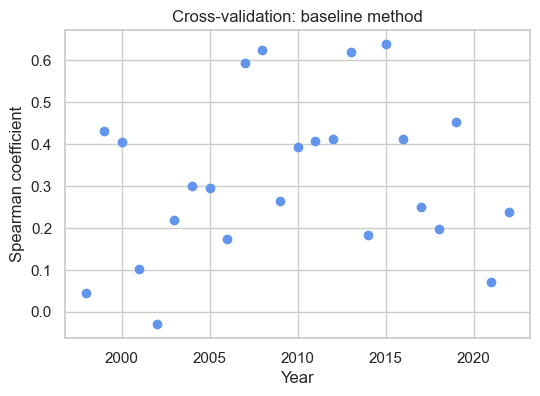

In [64]:
## NOTE: Slovakia only has one final entry in our dataset, in 1998.
## So, when the model is 'trained' on all data excluding 1998, Slovakia doesn't get a rescaled_rank as there is no data to work with.
## The 1998 predictions therefore don't include Slovakia (the Spearman coefficient is calculated based on all other entrants in 1998).

all_years = df['year'].unique()

def get_spearman_baseline_without(year):
    rescaled_ranks = train_baseline(excluded_years=[year])
    predictions_baseline = predict_baseline(rescaled_ranks, year)
    actual = get_actual_ranks(year)
    # Remove Slovakia from 1998
    if year == 1998:
        predictions_baseline = predictions_baseline.query('to_country != "slovakia"')
        actual = actual.query('to_country != "slovakia"')
    return(get_spearman(predictions_baseline, actual))
    
spearmans = [get_spearman_baseline_without(year) for year in all_years]

print(f'Mean Spearman coefficient across {len(all_years)} years: {np.mean(spearmans)}')

df_xv = pd.DataFrame({'year': all_years, 'spearman': spearmans})
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_xv['year'], df_xv['spearman'], color='#6495ed')
ax.set(xlabel='Year', ylabel='Spearman coefficient', title='Cross-validation: baseline method')
plt.show()

It turns out that *on average*, the historical results of a country at Eurovision are a half-decent indicator of how well they will perform in any given year.
Of course, this is hardly a surprise.
Interestingly, we can pick out years with lower Spearman correlations as being 'anomalies' in this regard, where an underdog won.
The year with the lowest value (that's 2002) featured Latvia as the winner, and perhaps even more surprisingly, the UK finished third ([Jessica Garlick with *'Come Back'*](https://www.youtube.com/watch?v=2NSR5rSk0Cs)).
When we write 'surprisingly', this is emphatically *not* us inserting our personal opinion: the baseline model in fact really dislikes the UK, assigning it the third-lowest average rescaled rank of all countries.
Thus, any year where the UK performs well is a surprise to our model!

Having looked at how good our model is at reproducing its own data, let's see what happens when we predict the 2023 results (now including all data from 1998 to 2022, inclusive, in our training).

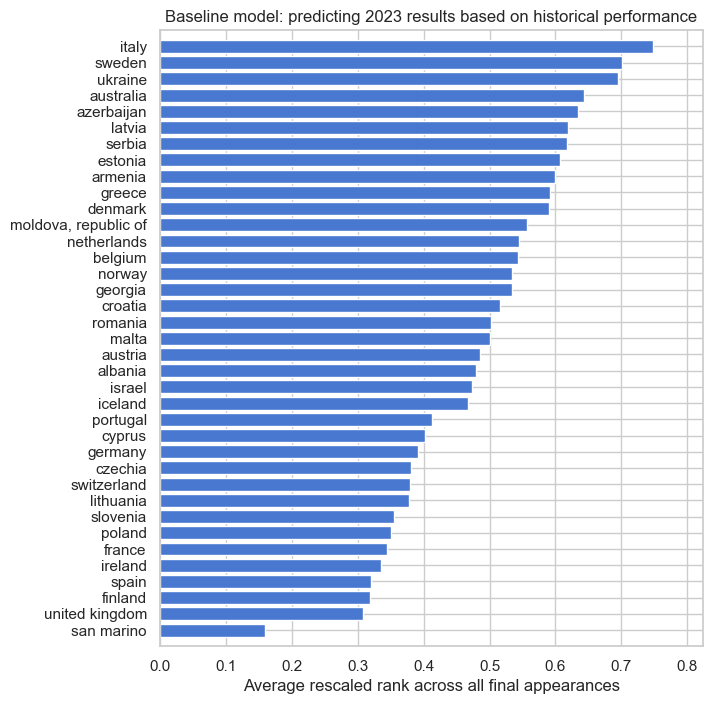

In [68]:
predictions_2023 = predict_baseline(train_baseline(), 2023)

n = len(predictions_2023)

fig, ax = plt.subplots(figsize=(7, 8))
ax.barh(width=predictions_2023['rescaled_rank'], y=np.arange(n), color='#4878D0')
ax.set(
    xlim=(0, predictions_2023['rescaled_rank'].max() * 1.1),
    ylim=(-1, n),
    yticks=np.arange(n),
    yticklabels=predictions_2023.index.values,
    xlabel='Average rescaled rank across all final appearances',
    title='Baseline model: predicting 2023 results based on historical performance'
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)
ax.invert_yaxis()
plt.show()

Our baseline model thus predicted Italy to come first, Sweden second, and Ukraine third, simply on the basis of them performing historically well at Eurovision.

In 2023, the top three countries were Sweden (with [Loreen's *Tattoo*](https://www.youtube.com/watch?v=b3vJfR81xO0)), Finland (with [Käärijä's *Cha Cha Cha*](https://www.youtube.com/watch?v=znWi3zN8Ucg)), and Israel (with [Noa Kirel's *Unicorn*](https://www.youtube.com/watch?v=r4wbdKmM3bQ)).
The full results of the final were as follows:

In [ ]:
actual_ranks_2023 = (future.loc[~np.isnan(future['rank'])]
                     .drop_duplicates(subset=['to_country'])
                     .loc[:, ['to_country', 'rank']]
                     .set_index('to_country'))

actual_ranks_2023.sort_values(by='rank').T

With the benefit of this hindsight, we can therefore calculate the Spearman correlation coefficient for 2023.
The Spearman coefficient is calculated only for countries which made the finals, since contestants eliminated in the semi-finals cannot really be assigned a 'rank'.

Spearman correlation for 2023: 0.432


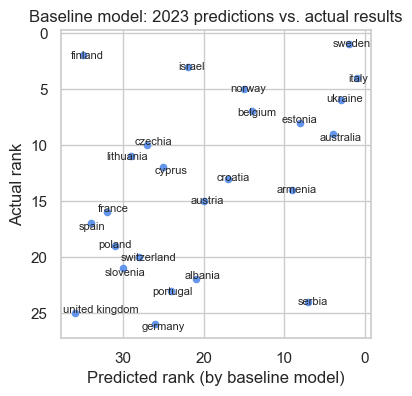

In [69]:
from adjustText import adjust_text

finalists_2023 = actual_ranks_2023.index.unique()
predictions_2023_finals = predictions_2023.query('to_country in @finalists_2023')

print(f'Spearman correlation for 2023: {get_spearman(predictions_2023_finals, actual_ranks_2023):.3f}')

both_2023 = join_predictions_and_actual(predictions_2023_finals, actual_ranks_2023)
ax = both_2023.plot(kind='scatter', x='predicted_rank', y='actual_rank', figsize=(4, 4), color='#6495ed')
ax.set(xlabel='Predicted rank (by baseline model)', ylabel='Actual rank', title='Baseline model: 2023 predictions vs. actual results')
texts = []
for i, txt in enumerate(both_2023.index):
    t = ax.text(s=txt, x=both_2023.iloc[i]['predicted_rank'], y=both_2023.iloc[i]['actual_rank'],
                ha='center', va='center', fontsize=8)
    texts.append(t)
ax.invert_xaxis(); ax.invert_yaxis()
adjust_text(texts, avoid_self=False)
plt.show()

## (2) Multi-level Bayesian Ordinal Regression Model

The bayesian model we developed models individual voting instances, rather than directly modelling the rank of a performance amoungst the competitors. Unlike the other models, an inter-country bias term is fitted for each voter-performer pair to attempt to capture any voting bias or 'favoritism' between countries. This approach was inspired by work done by Marta Blangiardo and Gianluca Baio, presented in their paper [Evidence of bias in the Eurovision songcontest: modelling the votes using Bayesianhierarchical models](https://www.tandfonline.com/doi/full/10.1080/02664763.2014.909792).

A drawback of this approach is that there is no constraint on the number of votes of a given score that one country may give out across round of voting. This is not representative of the real voting process that takes place, where each voter may only give out one score of 12, one of 10, etc. in a single round of voting.

In [71]:
import stan
import arviz as az
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import math

# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

Some futher pre-processing of the data is required to transform variables into a more suitable 
format. This includes encoding categorical variables as a binary representation and mapping the voting scores to a contiguous sequence from 1 to 11.

In [72]:
# Given gender is a categoric variable with 3 classes, encode as binary w.r.t default gender='group'
df['male'] = [1 if gender=='male' else 0 for gender in df['gender']]
df['female'] = [1 if gender=='female' else 0 for gender in df['gender']]

# Evaluate binary variables for boolean covariates to be used
df['Contains_English_bin'] = df['Contains_English'].apply(lambda x: 1 if x else 0)
df['Contains_Own_Language_bin'] = df['Contains_Own_Language'].apply(lambda x: 1 if x else 0)

def format_votes(x):
  if x == 12.:
    return 10
  elif x == 10.:
    return 9
  return int(x)
df['indexed_votes'] = df['points'].apply(format_votes) + 1
score_options = df['indexed_votes'].unique().tolist()
score_options.sort()
print(score_options)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Next we arranged an integer indexed look-up table of voter-performer pairs which will be used later 
to fit the inter-country bias parameters in the model. 

In [74]:
# build vector of voter/performer pair indicies and corresponding lookup tables
performers = sorted(df['to_code2'].unique())
voters = sorted(df['from_code2'].unique())
print(f"number of voters: {len(voters)}")
print(f"number of performers: {len(performers)}")
diff =  set(voters) - set(performers)
print(f'\nThose who have voted but not performed: {diff}')

# # create 0-indexed lookup tables for voter-performer pairings
vptoi = {}
itovp = {}
counter = 0
for p in performers:
    for v in voters:
        # only include v-p pairs that have occured in the data, different countries were voting and performing in different years
        if ( p != v ) and ( not df.loc[ (df['from_code2'] == v) & (df['to_code2'] == p) ].empty ):
            vptoi[f'{v}-{p}'] = counter
            itovp[f'{counter}'] = f'{v}-{p}'
            counter += 1

df['vp'] = df.apply(lambda x: vptoi[f'{x["from_code2"]}-{x["to_code2"]}'], axis=1)
print(f"\ncheck index of BE-HR: {vptoi['BE-HR']}")
print(f"check index of BE-CY: {vptoi['BE-CY']}")
df[ ["from_code2","to_code2","vp"]].head()

number of voters: 49
number of performers: 47

Those who have voted but not performed: {'AD', 'MC'}

check index of BE-HR: 993
check index of BE-CY: 474


from_code2 to_code2    vp
0         BE       HR   993
1         BE       CY   474
2         BE       EE   661
3         BE       MK  1461
4         BE       FI   755

In [75]:
# test/train split
# Reserve data from 2019-2022 for testing model on unseen data
print(f'full df shape: {df.shape}')
df_train = df.loc[ df['year'] <= 2018 ]
df_test = df.loc[ df['year'] > 2018 ]
print(f'train df shape: {df_train.shape}')
print(f'test df shape: {df_test.shape}')

full df shape: (21310, 35)
train df shape: (18307, 35)
test df shape: (3003, 35)


To use PyStan to fit a model with Markov Chain Monte Carlo (MCMC) sampling, a Stan program is 
defined as follows:

In [76]:
model = """
// overload add function for adding an int to an array of ints
functions {
  array[] int add(array[] int x, int y) {
      int x_size = size(x);
      array[x_size] int z;
      for (i in 1:x_size){
        z[i] = x[i] + y;
      }
      return z;
  }
}
data {
  int<lower=2> S;
  int<lower=0> N;   // total number of performances
  int<lower=1> B;   // number of performance dependent covariates
  int<lower=1> PHI; // number of voter/performer pair dependent covariates
  int<lower=1> VP;  // number of voter/performer combinations

  array[N] int<lower=1, upper=S> y;
  matrix[N,B] xbeta;       // performance dependent covariates
  matrix[VP,PHI] xphi;     // voter/performer pair dependent covariates
  array[N] int<lower=0,upper=VP-1> vp;  // voter/performer pair index

  int<lower=0> N_new; // number of predictions
  matrix[N_new,B] xbeta_new;
  array[N_new] int<lower=0,upper=VP-1> vp_new;

}
parameters {
  vector[B] beta;
  vector[PHI] phi;
  vector[VP] alpha;
  ordered[S-1] lambda;
  real gamma;
  real<lower=0> sigmaAlpha;
}
model {
  gamma ~ normal(0, 10000);
  beta ~ normal(0, 10000);
  lambda ~ normal(0, 3.2);
  sigmaAlpha ~ cauchy(0,1);

  alpha ~ normal( xphi * phi, sigmaAlpha );
  
  // remembering that vp is 0-indexed and alpha is 1-indexed
  y ~ ordered_logistic( gamma + alpha[ add(vp,1) ] + (xbeta * beta), lambda );

}
generated quantities {
  vector[N] y_hat;
  for (n in 1:N) {
    y_hat[n] = ordered_logistic_rng( gamma + alpha[ add(vp[n],1) ] + (xbeta[n] * beta), lambda);
  }

  // out of sample predictions (scores we expect to observe for new data)
  vector[N_new] y_pred;
  for (n_new in 1:N_new) {
    y_pred[n_new] = ordered_logistic_rng( gamma + alpha[ add(vp_new[n_new],1) ] + (xbeta_new[n_new] * beta), lambda);
  }
}
"""

The data is arranged into matricies with some tranformations, scaling and substitutions for missing 
values which should improve the fitting process.

mean = 0.0 count: 13
mean = nan count: 473

Note that 21.75% of the v-p pairs get the substitute value for migration intensity because there was no migration information.


Text(0.5, 1.0, 'distribution of available non-zero migration data (used to infer missing data)')

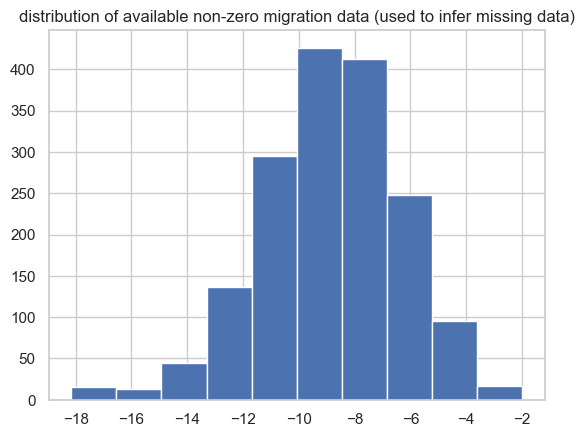

In [86]:
# build xbeta matrix
xbeta_train = df_train.loc[:,['Contains_English_bin','Contains_Own_Language_bin','male','female','comps_without_win']].values
# minmax scaling of 'comps_since_last_win'
scaler = MinMaxScaler() 
xbeta_train_norm = scaler.fit_transform(xbeta_train)

xbeta_test = df_test.loc[:,['Contains_English_bin','Contains_Own_Language_bin','male','female','comps_without_win']].values
# minmax scaling of 'comps_since_last_win'
xbeta_test_norm = scaler.transform(xbeta_test)

# build xphi matrix
xphi = np.zeros((len(vptoi), 2))
migration_means = []
zero_count = 0
nan_count = 0
for pair,idx in vptoi.items():
    v = pair[:2]
    p = pair[-2:]
    vp = df.loc[ (df['from_code2'] == v) & (df['to_code2'] == p) ]
    xphi[idx][0] = 1.0 if vp['has_border'].unique() else 0.0

    migration_series = vp['prop_emigrants_v2p']
    if migration_series.isnull().any():
        # if no migration data is available, use the plot below to infer the most appropriate substitute value
        # this should be a better alternative to assuming 0 migration
        xphi[idx][1] = math.exp(-9) - 2.6e-08/2
        nan_count += 1
    else:
        mean_migration = migration_series.mean()
        xphi[idx][1] = mean_migration

        # below lines for informational purpose
        if mean_migration == 0.0:
            zero_count +=1
        migration_means.append(mean_migration)

print(f'mean = 0.0 count: {zero_count}')
print(f'mean = nan count: {nan_count}')
print(f'\nNote that {round(100*nan_count/len(vptoi),2)}% of the v-p pairs get the substitute value for migration intensity because there was no migration information.')
plt.hist(np.log(np.array(migration_means) + 2.6e-08/2)) # translate by half of smallest non-zero value
plt.title('distribution of available non-zero migration data (used to infer missing data)')

smallest non-zero value: 2.6071052952733155e-08


Text(0.5, 1.0, 'normalised migration intensity values for 2175 v-p pairs')

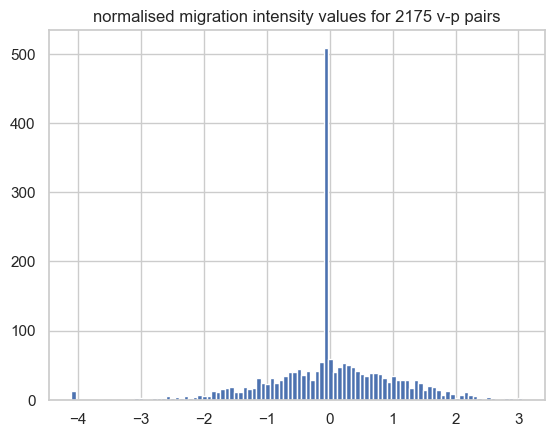

In [79]:
# standardise the migration intensity feature in xphi with a log transform and standardisation
mig_ints = xphi[:,1]
mig_ints_sort = np.sort(mig_ints)
print(f'smallest non-zero value: {mig_ints_sort[mig_ints_sort != 0][0]}')

mig_ints_log = np.log10(mig_ints + 2.6e-08/2)   # rule of thumb, half of smallest non-zero value
std_scaler = StandardScaler()
mig_ints_log_std = std_scaler.fit_transform(mig_ints_log.reshape(-1, 1))

# write scaler version of xphi
xphi_norm = xphi.copy()
xphi_norm[:,1] = mig_ints_log_std.reshape((2175,))

plt.hist(xphi_norm[:,1],bins=100)
plt.title(f'normalised migration intensity values for {len(vptoi)} v-p pairs')


The model is fit in the code cell below. As a word of warning, the sampling process is quite time-consuming.

In [82]:
data = {
    'S': 11,
    'N': df_train.shape[0],
    'B': xbeta_train_norm.shape[1],
    'PHI' : xphi_norm.shape[1],
    'VP' : xphi_norm.shape[0],
    'y': df_train['indexed_votes'].values,
    'xbeta': xbeta_train_norm,
    'xphi' : xphi_norm,
    'vp' : df_train['vp'].values,
    'N_new': df_test.shape[0],
    'xbeta_new': xbeta_test_norm,
    "vp_new" : df_test['vp'].values
}

posterior = stan.build(model, data=data)
# fit = posterior.sample(num_chains=2, num_warmup=1000, num_samples=300)
fit = posterior.sample(num_chains=2, num_warmup=100, num_samples=100)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_iw_qnh9r/model_pmweidjy.stan', line 40, column 19: Argument
    10000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_iw_qnh9r/model_pmweidjy.stan', line 39, column 20: Argument
    10000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/400)
Sampling:   0% (2/400)
Sampling:  25% (101/400)
Sampling:  26% (102/400)
Sampling:  50% (201/400)
Sampling:  50% (202/400)ERROR:asyncio:Future exception was 

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n4'}>]], dtype=object)

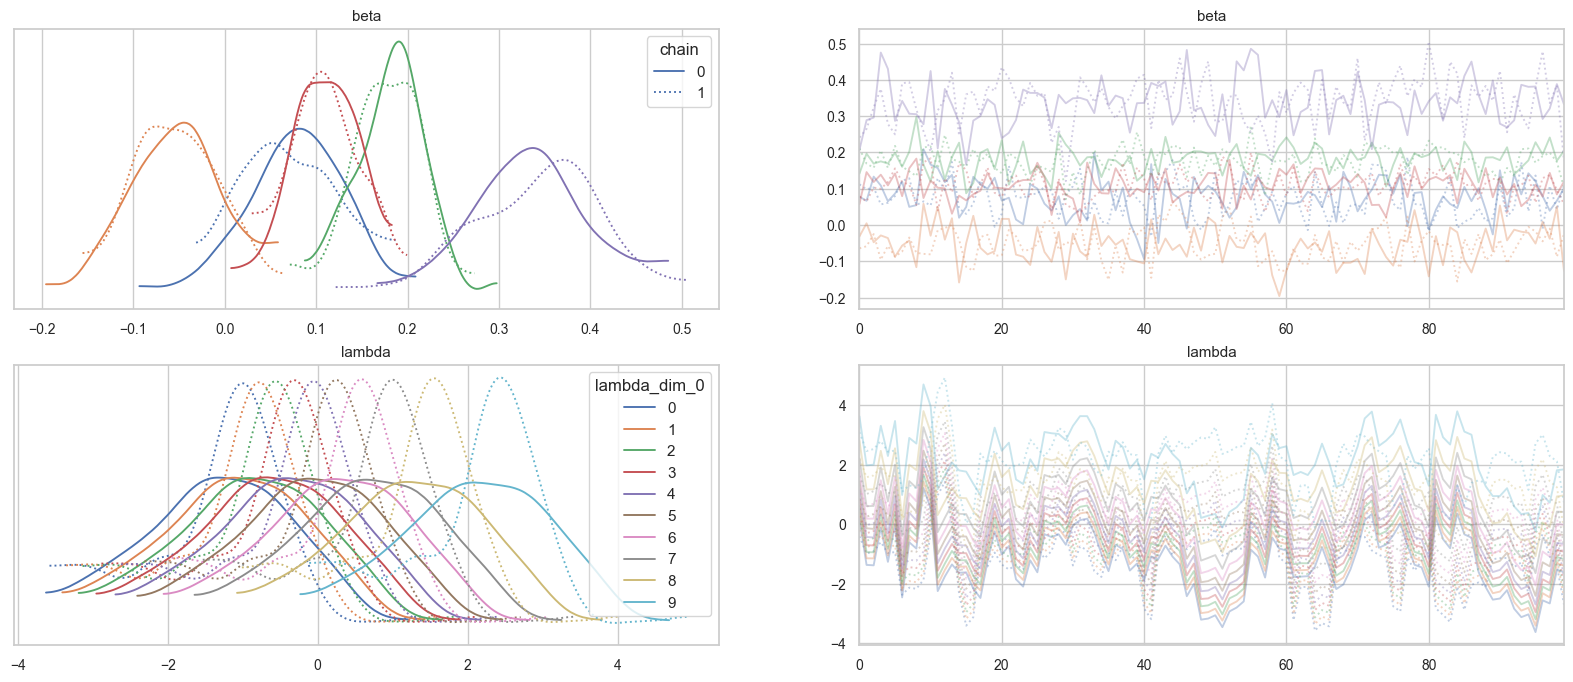

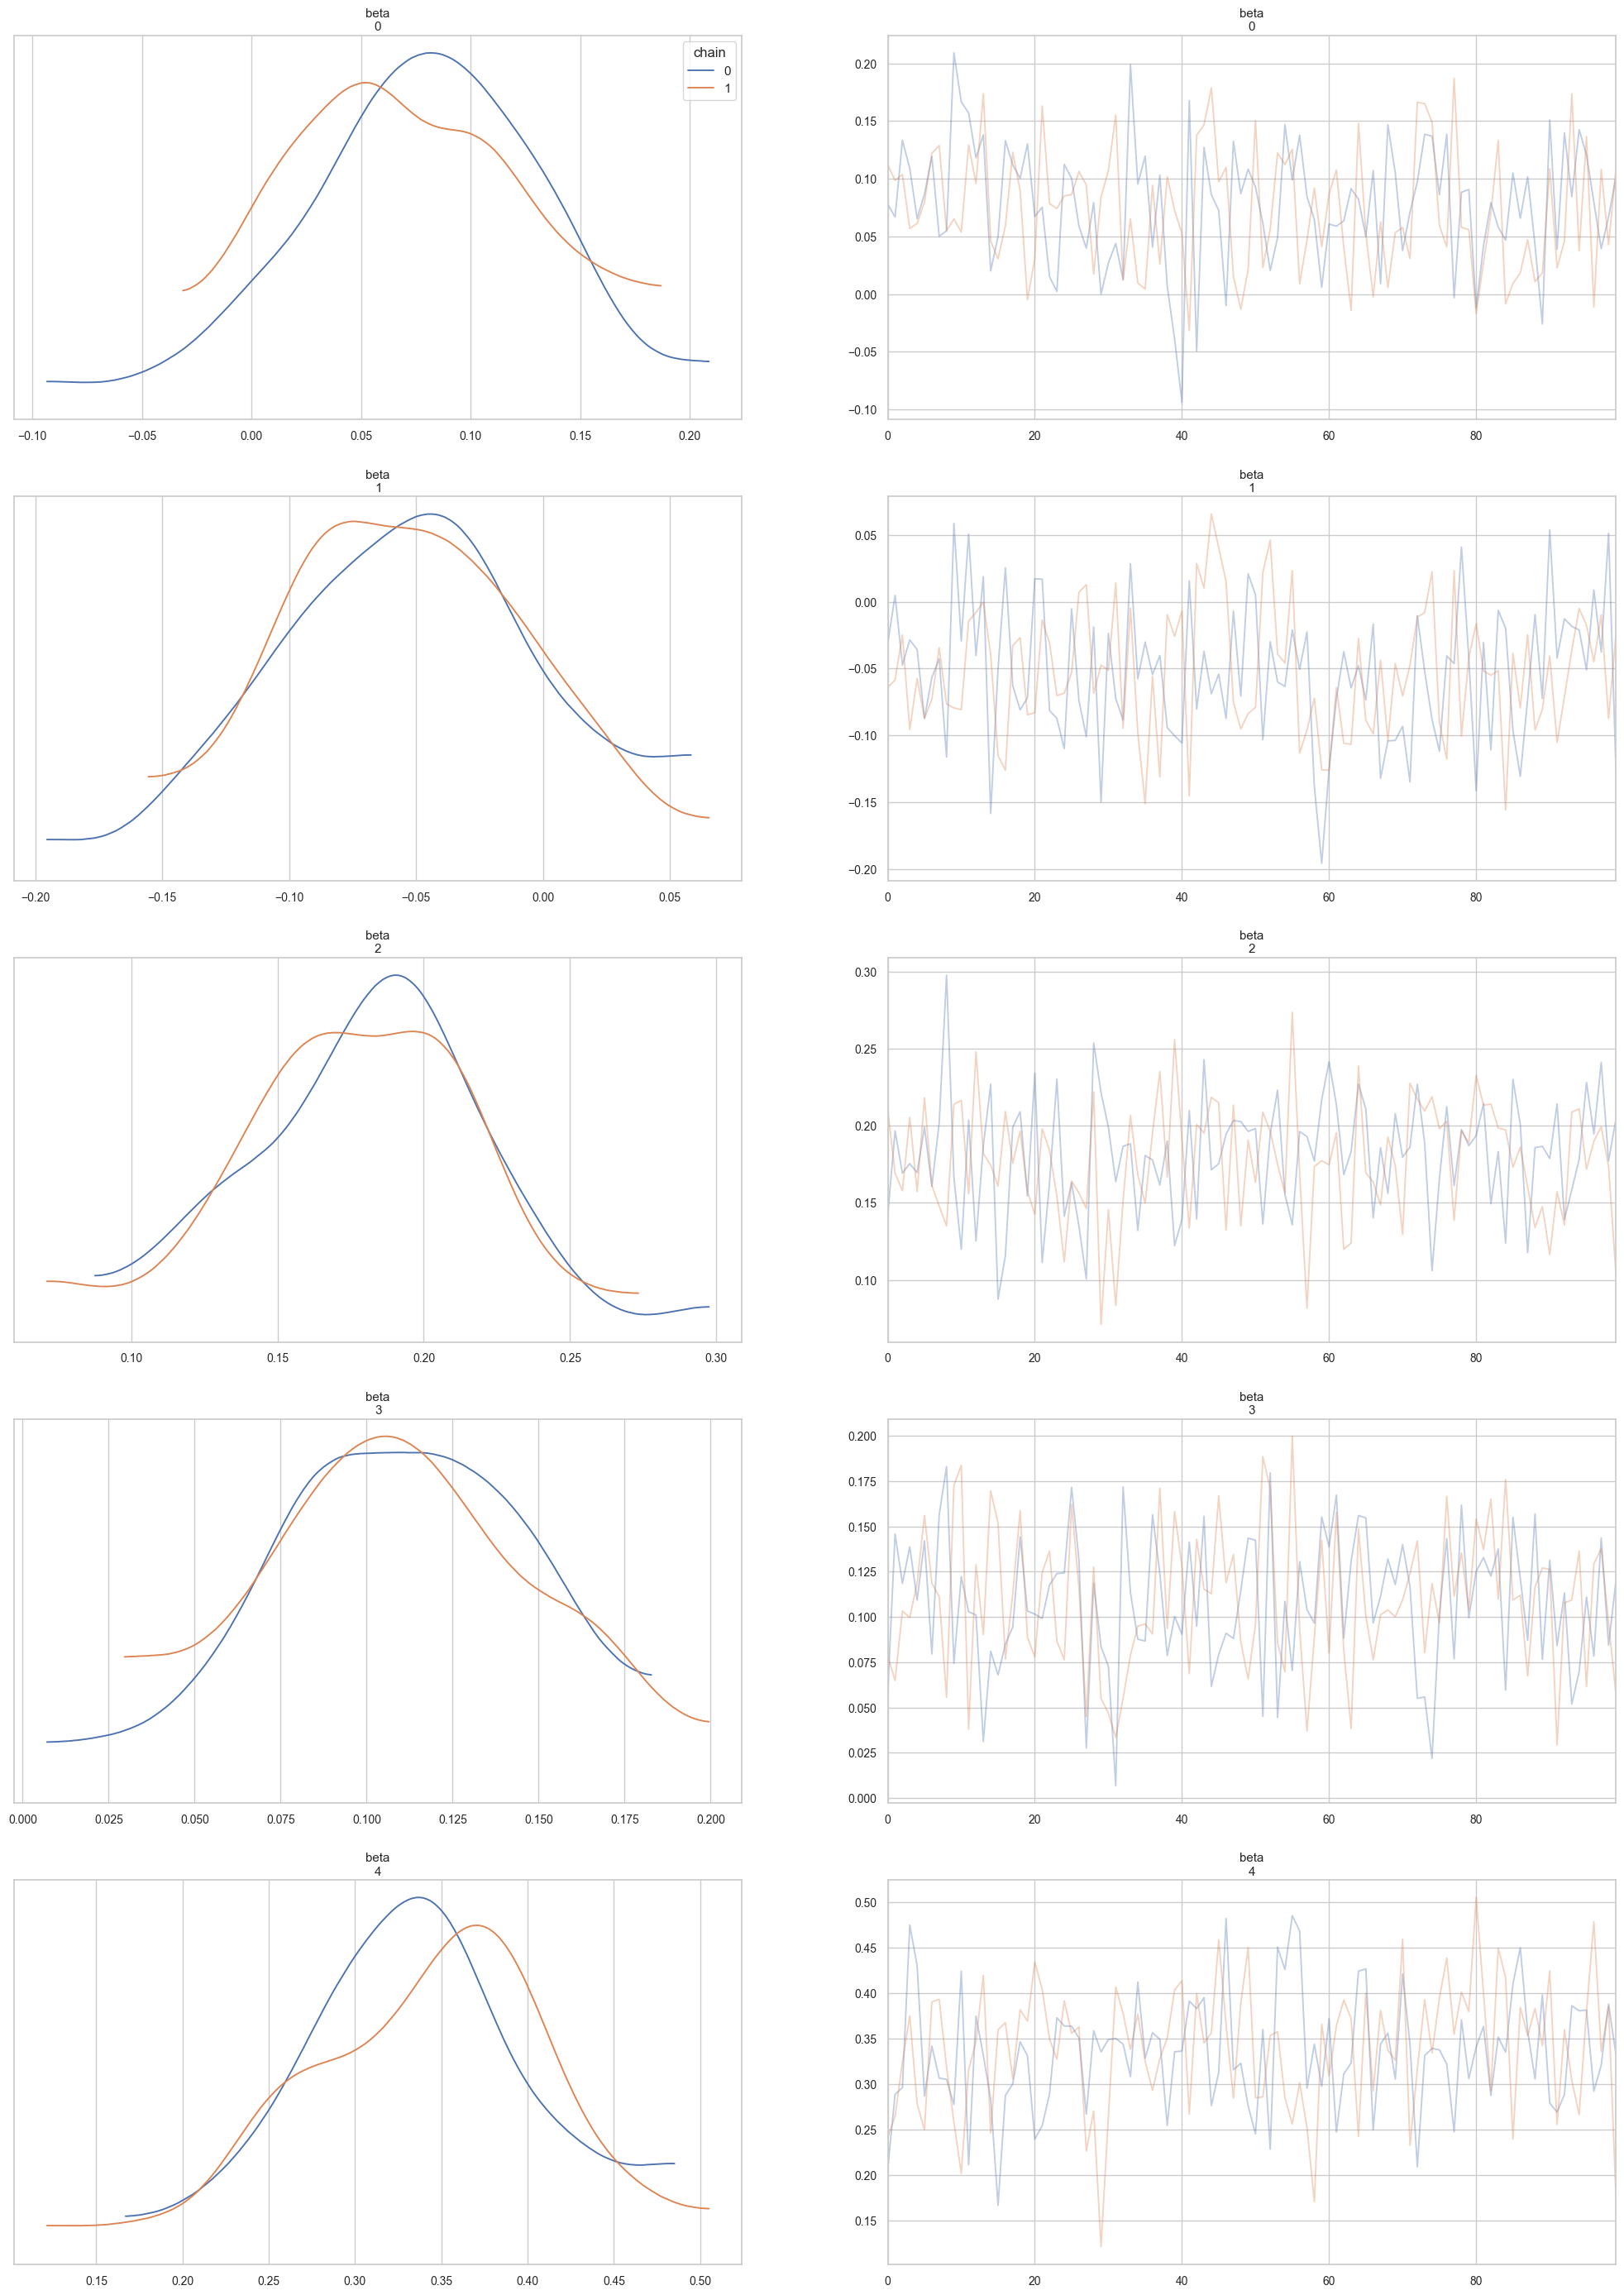

In [84]:
az_fit = az.from_pystan(
    posterior=fit, 
    observed_data="y", 
    posterior_predictive="y_hat",
    predictions="y_pred", 
    posterior_model=posterior)

az.plot_trace(az_fit, ["beta","lambda"], figsize=(20,8), legend=True)
az.plot_trace(az_fit, ["beta"], figsize=(25,35), legend=True, compact=False)

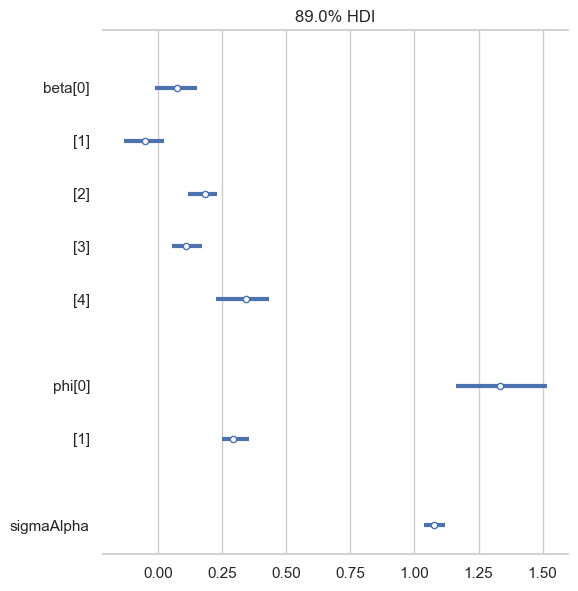

In [85]:
axes = az.plot_forest(az_fit,
                        kind='forestplot',
                        combined=True,
                        quartiles=False,
                        hdi_prob=0.89,
                        var_names=['beta','phi','sigmaAlpha']
                        )

## (3) Ranked XGBoost Model

Our XGBoost model also modelled the competition at the level of the individual votes. However, it was designed to model the behaviour of a voting country given a set of performances and a constrained set of votes to hand out (1, 2, 3, 4, 5, 6, 7, 8, 10, 12). In the same way as the Bayesian model, once the votes are cast the total score for each performer can be evaluated, and the competition ranking determined.

A ranked XGBoost (Extreme Gradient Boosting) model is a type of machine learning model that is used to predict rankings or orders of items.

The "XGBoost" part of the model name refers to the specific algorithm that is used to train the model. XGBoost is a gradient boosting algorithm that works by iteratively improving a weak model based on decision trees by adding new models that correct its errors. This process continues until the model is able to accurately predict the target variable, in this case the rankings of the products.

The "ranked" aspect of the model refers to the fact that it is specifically designed to predict rankings or orders, rather than just predicting individual values or classifications. This is useful in scenarios where the order or ranking of items is important, such as in search engine results or recommendation systems.

Overall, a ranked XGBoost model is a powerful machine learning tool that can be used to predict rankings or orders of items, based on various factors that may influence their positions in the ranking. This technique is often used to train XGBoost models for ranking tasks, such as search engine ranking or recommendation systems.

# Conclusions

Round everything up, draw conclusions.